In [1]:
# Cell 0: 环境配置和库导入
!pip install kneed
import os
import sys
import warnings
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm import tqdm
from pathlib import Path
import time
import traceback

# 设置环境变量解决Windows问题
os.environ['LOKY_MAX_CPU_COUNT'] = '1'
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1'

# 过滤警告
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)

print("环境配置完成，开始导入机器学习库...")

# 机器学习库
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import (
    silhouette_score, davies_bouldin_score, calinski_harabasz_score,
    adjusted_rand_score, normalized_mutual_info_score,
    homogeneity_completeness_v_measure, confusion_matrix,
    classification_report
)

print("正在导入深度学习库...")

# 深度学习特征提取
try:
    import torch
    import torch.nn as nn
    import torchvision.models as models
    import torchvision.transforms as transforms
    from torchvision.models import ResNet50_Weights, VGG16_Weights
    print("PyTorch导入成功")
except ImportError as e:
    print(f"PyTorch导入失败: {e}")
    print("将使用传统特征提取方法")

# 设置随机种子确保可重复性
np.random.seed(42)
if 'torch' in sys.modules:
    torch.manual_seed(42)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(42)

print("所有库导入完成！")
print(f"NumPy版本: {np.__version__}")
print(f"Pandas版本: {pd.__version__}")

环境配置完成，开始导入机器学习库...
正在导入深度学习库...
PyTorch导入成功
所有库导入完成！
NumPy版本: 1.26.4
Pandas版本: 2.2.2


In [2]:
# Cell 1: ImageClustering类的初始化部分
class ImageClustering:
    def __init__(self, data_dir='dataset/', labels_file='cluster_labels.json', 
                 device='auto', feature_type='deep'):
        """
        初始化图像聚类类
        
        参数:
        data_dir: 图像数据目录
        labels_file: 真实标签文件
        device: 'auto', 'cpu' 或 'cuda'
        feature_type: 特征类型 ('deep', 'hybrid', 'traditional')
        """
        self.data_dir = Path(data_dir)
        self.labels_file = labels_file
        self.feature_type = feature_type
        
        # 检查目录是否存在
        if not self.data_dir.exists():
            raise ValueError(f"数据目录不存在: {data_dir}")
        if not Path(labels_file).exists():
            raise ValueError(f"标签文件不存在: {labels_file}")
        
        # 初始化变量
        self.image_paths = []
        self.image_names = []
        self.true_labels = []
        self.true_labels_encoded = []
        self.features = None
        self.features_scaled = None
        self.cluster_labels = None
        self.label_encoder = {}
        self.label_decoder = {}
        
        # 加载数据
        print("正在加载数据...")
        self.load_data()
        
        # 设置设备
        self.set_device(device)
        
        # 初始化特征提取器
        self.init_feature_extractor()
        
        print(f"初始化完成: {len(self.image_paths)}张图像, {len(self.label_encoder)}个类别")
        print(f"设备: {self.device}, 特征类型: {self.feature_type}")
    
    def set_device(self, device):
        """设置计算设备"""
        if device == 'auto':
            if 'torch' in sys.modules and torch.cuda.is_available():
                self.device = torch.device('cuda')
                print(f"使用GPU: {torch.cuda.get_device_name(0)}")
            else:
                self.device = torch.device('cpu')
                print("使用CPU")
        else:
            self.device = torch.device(device)
    
    def load_data(self):
        """加载图像路径和标签"""
        # 加载JSON标签文件
        with open(self.labels_file, 'r') as f:
            labels_dict = json.load(f)
        
        # 按文件名排序
        sorted_items = sorted(labels_dict.items())
        
        for img_name, label in sorted_items:
            img_path = self.data_dir / img_name
            if img_path.exists():
                self.image_paths.append(img_path)
                self.image_names.append(img_name)
                self.true_labels.append(label)
            else:
                print(f"警告: 图像文件不存在 {img_path}")
        
        if len(self.image_paths) == 0:
            raise ValueError("没有找到任何有效的图像文件")
        
        # 创建标签编码器
        unique_labels = sorted(set(self.true_labels))
        self.label_encoder = {label: idx for idx, label in enumerate(unique_labels)}
        self.label_decoder = {idx: label for label, idx in self.label_encoder.items()}
        self.true_labels_encoded = [self.label_encoder[label] for label in self.true_labels]
        
        # 打印类别分布
        label_counts = pd.Series(self.true_labels).value_counts().to_dict()
        print("类别分布:")
        for label, count in label_counts.items():
            print(f"  {label}: {count}张 ({count/len(self.image_paths)*100:.1f}%)")
    
    def init_feature_extractor(self):
        """初始化特征提取器"""
        if self.feature_type in ['deep', 'hybrid'] and 'torch' not in sys.modules:
            print("警告: PyTorch不可用，将使用传统特征")
            self.feature_type = 'traditional'
        
        if self.feature_type in ['deep', 'hybrid']:
            # 创建图像预处理流水线
            self.transform = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                   std=[0.229, 0.224, 0.225])
            ])
            
            # 加载预训练模型
            try:
                self.model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
                # 移除最后的全连接层
                self.model = nn.Sequential(*list(self.model.children())[:-1])
                self.model = self.model.to(self.device)
                self.model.eval()
                print("ResNet50模型加载成功")
            except Exception as e:
                print(f"无法加载ResNet50模型: {e}")
                print("将使用传统特征提取方法")
                self.feature_type = 'traditional'

In [3]:
# Cell 2: 特征提取方法
def extract_deep_features(self, batch_size=32):
    """使用预训练模型提取深度特征"""
    print("正在提取深度特征...")
    
    if not hasattr(self, 'model'):
        raise ValueError("深度学习模型未初始化")
    
    features_list = []
    total_images = len(self.image_paths)
    
    # 使用数据加载器分批处理
    with torch.no_grad():
        for i in tqdm(range(0, total_images, batch_size), 
                     desc="提取深度特征", 
                     total=(total_images + batch_size - 1) // batch_size):
            
            batch_paths = self.image_paths[i:i+batch_size]
            batch_features = []
            
            for img_path in batch_paths:
                try:
                    # 加载和预处理图像
                    img = Image.open(img_path).convert('RGB')
                    img_tensor = self.transform(img).unsqueeze(0).to(self.device)
                    
                    # 提取特征
                    feature = self.model(img_tensor)
                    feature = feature.squeeze().cpu().numpy().flatten()
                    batch_features.append(feature)
                    
                except Exception as e:
                    print(f"处理图像 {img_path} 时出错: {e}")
                    # 使用零向量作为占位符
                    if len(batch_features) > 0:
                        batch_features.append(np.zeros_like(batch_features[0]))
                    else:
                        # 如果是第一个特征，需要知道特征维度
                        # 暂时使用零向量，稍后会知道维度
                        batch_features.append(np.zeros(2048))  # ResNet50特征维度
    
            if batch_features:
                features_list.extend(batch_features)
    
    # 转换为numpy数组
    self.features = np.array(features_list)
    
    # 检查特征维度是否一致
    if len(self.features.shape) != 2:
        print(f"警告: 特征维度不正确 {self.features.shape}，尝试修复...")
        # 尝试统一维度
        max_dim = max(feat.shape[0] for feat in self.features)
        aligned_features = []
        for feat in self.features:
            if feat.shape[0] < max_dim:
                # 填充零
                aligned = np.zeros(max_dim)
                aligned[:feat.shape[0]] = feat
                aligned_features.append(aligned)
            else:
                aligned_features.append(feat[:max_dim])
        self.features = np.array(aligned_features)
    
    print(f"深度特征提取完成，特征形状: {self.features.shape}")
    
    # 标准化特征
    self.scaler = StandardScaler()
    self.features_scaled = self.scaler.fit_transform(self.features)
    
    return self.features_scaled

def extract_color_histogram_features(self):
    """提取颜色直方图特征"""
    print("正在提取颜色直方图特征...")
    
    color_features = []
    
    for img_path in tqdm(self.image_paths, desc="提取颜色特征"):
        try:
            img = Image.open(img_path).convert('RGB')
            img_np = np.array(img)
            
            # 计算RGB颜色直方图
            hist_r = np.histogram(img_np[:,:,0].flatten(), bins=32, range=[0,256])[0]
            hist_g = np.histogram(img_np[:,:,1].flatten(), bins=32, range=[0,256])[0]
            hist_b = np.histogram(img_np[:,:,2].flatten(), bins=32, range=[0,256])[0]
            
            # 计算HSV颜色直方图
            img_hsv = Image.open(img_path).convert('HSV')
            img_hsv_np = np.array(img_hsv)
            hist_h = np.histogram(img_hsv_np[:,:,0].flatten(), bins=32, range=[0,256])[0]
            hist_s = np.histogram(img_hsv_np[:,:,1].flatten(), bins=32, range=[0,256])[0]
            hist_v = np.histogram(img_hsv_np[:,:,2].flatten(), bins=32, range=[0,256])[0]
            
            # 计算LAB颜色直方图
            from skimage.color import rgb2lab
            if img_np.shape[0] > 0 and img_np.shape[1] > 0:
                img_lab = rgb2lab(img_np)
                hist_l = np.histogram(img_lab[:,:,0].flatten(), bins=32, range=[0,100])[0]
                hist_a = np.histogram(img_lab[:,:,1].flatten(), bins=32, range=[-128,127])[0]
                hist_b_lab = np.histogram(img_lab[:,:,2].flatten(), bins=32, range=[-128,127])[0]
            else:
                hist_l = hist_a = hist_b_lab = np.zeros(32)
            
            # 组合所有颜色特征
            color_feature = np.concatenate([
                hist_r, hist_g, hist_b,
                hist_h, hist_s, hist_v,
                hist_l, hist_a, hist_b_lab
            ])
            
            # 归一化
            color_feature = color_feature / (np.sum(color_feature) + 1e-8)
            color_features.append(color_feature)
            
        except Exception as e:
            print(f"处理图像 {img_path} 时出错: {e}")
            color_features.append(np.zeros(288))  # 32*9=288
    
    color_features = np.array(color_features)
    print(f"颜色直方图特征形状: {color_features.shape}")
    
    return color_features

def extract_texture_features(self):
    """提取纹理特征"""
    print("正在提取纹理特征...")
    
    try:
        from skimage.feature import graycomatrix, graycoprops
        from skimage import color, img_as_ubyte
    except ImportError:
        print("skimage不可用，跳过纹理特征提取")
        return None
    
    texture_features = []
    
    for img_path in tqdm(self.image_paths, desc="提取纹理特征"):
        try:
            img = Image.open(img_path).convert('L')  # 转为灰度
            img_np = np.array(img)
            
            # 调整图像大小以加快处理
            if img_np.shape[0] > 256 or img_np.shape[1] > 256:
                from PIL import Image as PILImage
                img_resized = PILImage.fromarray(img_np).resize((256, 256))
                img_np = np.array(img_resized)
            
            # 转换为8位无符号整数
            img_ubyte = img_as_ubyte(img_np)
            
            # 计算灰度共生矩阵
            glcm = graycomatrix(img_ubyte, distances=[1, 2, 4], 
                               angles=[0, np.pi/4, np.pi/2, 3*np.pi/4],
                               levels=256, symmetric=True, normed=True)
            
            # 提取纹理属性
            properties = ['contrast', 'dissimilarity', 'homogeneity', 
                         'energy', 'correlation', 'ASM']
            texture_feature = []
            for prop in properties:
                prop_values = graycoprops(glcm, prop)
                texture_feature.extend(prop_values.flatten())
            
            texture_features.append(np.array(texture_feature))
            
        except Exception as e:
            print(f"处理图像 {img_path} 时出错: {e}")
            # 使用零向量
            texture_features.append(np.zeros(72))  # 6个属性 * 3个距离 * 4个角度
    
    texture_features = np.array(texture_features)
    print(f"纹理特征形状: {texture_features.shape}")
    
    return texture_features

def extract_hybrid_features(self):
    """提取混合特征：深度特征 + 颜色直方图 + 纹理特征"""
    print("正在提取混合特征...")
    
    # 提取深度特征
    deep_features = self.extract_deep_features()
    
    # 提取颜色特征
    color_features = self.extract_color_histogram_features()
    
    # 提取纹理特征
    texture_features = self.extract_texture_features()
    
    # 组合特征
    feature_list = [deep_features]
    
    if color_features is not None and len(color_features) == len(deep_features):
        # 标准化颜色特征
        color_scaler = StandardScaler()
        color_features_scaled = color_scaler.fit_transform(color_features)
        feature_list.append(color_features_scaled)
    
    if texture_features is not None and len(texture_features) == len(deep_features):
        # 标准化纹理特征
        texture_scaler = StandardScaler()
        texture_features_scaled = texture_scaler.fit_transform(texture_features)
        feature_list.append(texture_features_scaled)
    
    # 水平拼接所有特征
    self.hybrid_features = np.hstack(feature_list)
    print(f"混合特征形状: {self.hybrid_features.shape}")
    
    # 标准化混合特征
    self.hybrid_scaler = StandardScaler()
    self.hybrid_features_scaled = self.hybrid_scaler.fit_transform(self.hybrid_features)
    
    return self.hybrid_features_scaled

def extract_features(self):
    """根据设置的特征类型提取特征"""
    if self.feature_type == 'deep':
        return self.extract_deep_features()
    elif self.feature_type == 'hybrid':
        return self.extract_hybrid_features()
    elif self.feature_type == 'traditional':
        # 只使用颜色和纹理特征
        color_features = self.extract_color_histogram_features()
        texture_features = self.extract_texture_features()
        
        if texture_features is not None:
            features = np.hstack([color_features, texture_features])
        else:
            features = color_features
        
        self.scaler = StandardScaler()
        features_scaled = self.scaler.fit_transform(features)
        return features_scaled
    else:
        raise ValueError(f"不支持的特征类型: {self.feature_type}")

# 将方法添加到类中
ImageClustering.extract_deep_features = extract_deep_features
ImageClustering.extract_color_histogram_features = extract_color_histogram_features
ImageClustering.extract_texture_features = extract_texture_features
ImageClustering.extract_hybrid_features = extract_hybrid_features
ImageClustering.extract_features = extract_features

print("特征提取方法定义完成！")

特征提取方法定义完成！


In [4]:
# Cell 3: 降维方法 (已修正TSNE参数兼容性问题)
def reduce_dimension(self, features, method='pca', n_components=50, 
                    perplexity=30, random_state=42):
    """
    降维以便可视化
    
    参数:
    method: 'pca', 'tsne', 'umap', 'both'
    n_components: 降维后的维度
    perplexity: t-SNE的困惑度参数
    """
    
    print(f"使用 {method} 方法降维...")
    
    if method == 'pca':
        # PCA降维
        start_time = time.time()
        pca = PCA(n_components=min(n_components, features.shape[1]), 
                 random_state=random_state)
        features_reduced = pca.fit_transform(features)
        
        explained_variance = np.sum(pca.explained_variance_ratio_)
        print(f"PCA完成，保留方差: {explained_variance:.3f}")
        print(f"主成分贡献: {pca.explained_variance_ratio_[:5]}")
        print(f"耗时: {time.time() - start_time:.2f}秒")
        
        return features_reduced
    
    elif method == 'tsne':
        # t-SNE降维
        print("t-SNE降维可能需要较长时间，请耐心等待...")
        start_time = time.time()
        
        # 如果特征维度太高，先使用PCA降维
        if features.shape[1] > 50:
            print("特征维度较高，先使用PCA预降维...")
            pca = PCA(n_components=50, random_state=random_state)
            features_pca = pca.fit_transform(features)
            print(f"PCA预降维完成，保留方差: {np.sum(pca.explained_variance_ratio_):.3f}")
        else:
            features_pca = features
        
        # 应用t-SNE - 已修正：将 `n_iter` 改为 `max_iter`
        tsne = TSNE(n_components=2, 
                   perplexity=min(perplexity, len(features_pca)-1),
                   random_state=random_state,
                   max_iter=1000,           # 关键修改处：旧参数名 n_iter -> 新参数名 max_iter
                   learning_rate='auto',
                   init='random')
        
        features_reduced = tsne.fit_transform(features_pca)
        print(f"t-SNE完成，耗时: {time.time() - start_time:.2f}秒")
        
        return features_reduced
    
    elif method == 'both':
        # 先PCA再t-SNE
        print("使用PCA+t-SNE组合降维...")
        start_time = time.time()
        
        # PCA降维到50维
        pca = PCA(n_components=min(50, features.shape[1]), 
                 random_state=random_state)
        features_pca = pca.fit_transform(features)
        explained_variance = np.sum(pca.explained_variance_ratio_)
        print(f"PCA完成，保留方差: {explained_variance:.3f}")
        
        # t-SNE降维到2维 - 同样需要修正参数名
        tsne = TSNE(n_components=2, 
                   perplexity=perplexity,
                   random_state=random_state,
                   max_iter=1000)           # 关键修改处：旧参数名 n_iter -> 新参数名 max_iter
        
        features_tsne = tsne.fit_transform(features_pca)
        print(f"t-SNE完成，总耗时: {time.time() - start_time:.2f}秒")
        
        return features_tsne
    
    elif method == 'umap':
        # UMAP降维
        try:
            import umap
            print("使用UMAP降维...")
            start_time = time.time()
            
            reducer = umap.UMAP(n_components=min(n_components, 2),
                               random_state=random_state,
                               n_neighbors=15,
                               min_dist=0.1,
                               metric='euclidean')
            
            features_reduced = reducer.fit_transform(features)
            print(f"UMAP完成，耗时: {time.time() - start_time:.2f}秒")
            
            return features_reduced
        except ImportError:
            print("UMAP库未安装，将使用PCA替代")
            return self.reduce_dimension(features, method='pca', 
                                        n_components=n_components)
    
    else:
        raise ValueError(f"不支持的降维方法: {method}")

def visualize_feature_space(self, features_2d, labels=None, title="特征空间可视化"):
    """可视化特征空间"""
    if labels is None:
        labels = self.true_labels_encoded
    
    plt.figure(figsize=(12, 10))
    
    # 获取唯一标签
    unique_labels = np.unique(labels)
    n_labels = len(unique_labels)
    
    # 使用颜色映射
    if n_labels <= 10:
        cmap = plt.cm.tab10
    else:
        cmap = plt.cm.tab20
    
    # 绘制散点图
    scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], 
                         c=labels, cmap=cmap, alpha=0.7, s=30, 
                         edgecolors='w', linewidth=0.5)
    
    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlabel('Dimension 1', fontsize=12)
    plt.ylabel('Dimension 2', fontsize=12)
    
    # 添加颜色条
    cbar = plt.colorbar(scatter, ticks=range(n_labels))
    if n_labels <= 10:
        cbar.set_ticklabels([self.label_decoder.get(i, f'Label {i}') 
                            for i in range(n_labels)])
    
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# 将方法添加到类中
ImageClustering.reduce_dimension = reduce_dimension
ImageClustering.visualize_feature_space = visualize_feature_space

print("降维方法定义完成！(已修正TSNE参数)")

降维方法定义完成！(已修正TSNE参数)


In [5]:
# Cell 4: 聚类算法 (保留kneed依赖，增强GMM稳定性)
def apply_clustering(self, features, method='kmeans', n_clusters=None, **kwargs):
    """
    应用聚类算法
    
    参数:
    features: 特征矩阵
    method: 聚类方法 ('kmeans', 'dbscan', 'agglomerative', 'gmm', 'spectral', 'optics')
    n_clusters: 簇的数量，如果为None则自动确定
    **kwargs: 其他算法特定参数
    """
    
    print(f"应用 {method} 聚类算法...")
    
    if n_clusters is None:
        n_clusters = len(self.label_encoder)
        print(f"自动设置簇数为类别数: {n_clusters}")
    
    start_time = time.time()
    
    if method == 'kmeans':
        # K-means聚类
        kmeans_kwargs = {
            'n_clusters': n_clusters,
            'random_state': 42,
            'n_init': 10,
            'max_iter': 300,
            'tol': 1e-4,
            'algorithm': 'lloyd'  # 使用lloyd算法，避免elkan的Windows问题
        }
        
        # 更新用户提供的参数
        kmeans_kwargs.update(kwargs)
        
        clusterer = KMeans(**kmeans_kwargs)
        self.cluster_labels = clusterer.fit_predict(features)
        self.cluster_centers = clusterer.cluster_centers_
        self.inertia = clusterer.inertia_
        print(f"K-means完成，惯性值: {self.inertia:.2f}")
    
    elif method == 'dbscan':
        # DBSCAN密度聚类
        dbscan_kwargs = {
            'eps': 0.5,
            'min_samples': 5,
            'metric': 'euclidean',
            'n_jobs': 1
        }
        dbscan_kwargs.update(kwargs)
        
        clusterer = DBSCAN(**dbscan_kwargs)
        self.cluster_labels = clusterer.fit_predict(features)
        
        # 统计聚类结果
        unique_labels = np.unique(self.cluster_labels)
        n_clusters_found = len(unique_labels[unique_labels != -1])
        n_noise = np.sum(self.cluster_labels == -1)
        print(f"DBSCAN完成，发现 {n_clusters_found} 个簇，噪声点: {n_noise}")
    
    elif method == 'agglomerative':
        # 层次聚类
        agglomerative_kwargs = {
            'n_clusters': n_clusters,
            'metric': 'euclidean',
            'linkage': 'ward',
            'compute_full_tree': 'auto'
        }
        agglomerative_kwargs.update(kwargs)
        
        clusterer = AgglomerativeClustering(**agglomerative_kwargs)
        self.cluster_labels = clusterer.fit_predict(features)
        print(f"层次聚类完成")
    
    elif method == 'gmm':
        # 高斯混合模型 - 增强稳定性版本
        print("尝试GMM聚类，正在调整参数以增强稳定性...")
        
        # 尝试不同配置以找到能工作的参数
        gmm_configs = [
            {
                'n_components': n_clusters,
                'random_state': 42,
                'covariance_type': 'diag',  # 使用对角协方差，更稳定
                'max_iter': 200,
                'tol': 1e-3,
                'reg_covar': 1e-4,  # 增加正则化，防止协方差矩阵奇异
                'init_params': 'kmeans'
            },
            {
                'n_components': n_clusters,
                'random_state': 42,
                'covariance_type': 'spherical',  # 球形协方差，最简单
                'max_iter': 200,
                'tol': 1e-3,
                'reg_covar': 1e-3,  # 进一步增加正则化
                'init_params': 'kmeans'
            },
            {
                'n_components': max(2, n_clusters-1),  # 减少一个分量
                'random_state': 42,
                'covariance_type': 'diag',
                'max_iter': 200,
                'tol': 1e-3,
                'reg_covar': 1e-5,
                'init_params': 'kmeans'
            }
        ]
        
        gmm_success = False
        last_error = None
        
        for i, gmm_kwargs in enumerate(gmm_configs):
            gmm_kwargs.update(kwargs)  # 仍然允许用户覆盖参数
            
            try:
                print(f"尝试GMM配置 {i+1}/{len(gmm_configs)}: covariance_type={gmm_kwargs['covariance_type']}, reg_covar={gmm_kwargs['reg_covar']}")
                
                # 确保数据是float64类型，提高数值稳定性
                features_float64 = features.astype(np.float64) if features.dtype != np.float64 else features
                
                clusterer = GaussianMixture(**gmm_kwargs)
                clusterer.fit(features_float64)
                self.cluster_labels = clusterer.predict(features_float64)
                self.gmm_means = clusterer.means_
                self.gmm_covariances = clusterer.covariances_
                
                bic_score = clusterer.bic(features_float64)
                aic_score = clusterer.aic(features_float64)
                print(f"GMM配置 {i+1} 成功! BIC: {bic_score:.2f}, AIC: {aic_score:.2f}")
                
                gmm_success = True
                self.gmm_config_used = f"config_{i+1}"
                break
                
            except Exception as e:
                last_error = str(e)
                print(f"GMM配置 {i+1} 失败: {e}")
                continue
        
        if not gmm_success:
            print(f"所有GMM配置都失败了，最后错误: {last_error}")
            print("将使用K-means作为备用方案...")
            
            # 使用K-means作为备用
            backup_kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
            self.cluster_labels = backup_kmeans.fit_predict(features)
            self.cluster_centers = backup_kmeans.cluster_centers_
            self.inertia = backup_kmeans.inertia_
            print(f"已使用K-means备用方案完成，惯性值: {self.inertia:.2f}")
            
            # 标记这是备用结果
            self.gmm_fallback = True
    
    elif method == 'spectral':
        # 谱聚类
        try:
            from sklearn.cluster import SpectralClustering
            spectral_kwargs = {
                'n_clusters': n_clusters,
                'random_state': 42,
                'affinity': 'nearest_neighbors',
                'n_neighbors': 10,
                'assign_labels': 'kmeans',
                'n_jobs': 1
            }
            spectral_kwargs.update(kwargs)
            
            clusterer = SpectralClustering(**spectral_kwargs)
            self.cluster_labels = clusterer.fit_predict(features)
            print(f"谱聚类完成")
        except ImportError:
            print("谱聚类需要scikit-learn >= 0.22，使用K-means替代")
            return self.apply_clustering(features, method='kmeans', 
                                        n_clusters=n_clusters, **kwargs)
    
    elif method == 'optics':
        # OPTICS聚类
        try:
            from sklearn.cluster import OPTICS
            optics_kwargs = {
                'min_samples': 5,
                'metric': 'euclidean',
                'cluster_method': 'xi',
                'n_jobs': 1
            }
            optics_kwargs.update(kwargs)
            
            clusterer = OPTICS(**optics_kwargs)
            self.cluster_labels = clusterer.fit_predict(features)
            
            unique_labels = np.unique(self.cluster_labels)
            n_clusters_found = len(unique_labels[unique_labels != -1])
            print(f"OPTICS完成，发现 {n_clusters_found} 个簇")
        except ImportError:
            print("OPTICS需要scikit-learn >= 0.21，使用DBSCAN替代")
            return self.apply_clustering(features, method='dbscan', 
                                        n_clusters=n_clusters, **kwargs)
    
    else:
        raise ValueError(f"不支持的聚类方法: {method}")
    
    # 统计聚类结果
    unique_clusters = np.unique(self.cluster_labels)
    n_clusters_found = len(unique_clusters[unique_clusters != -1])  # 排除噪声标签-1
    
    print(f"聚类完成，发现 {n_clusters_found} 个簇")
    print(f"簇标签分布: {dict(zip(*np.unique(self.cluster_labels, return_counts=True)))}")
    print(f"耗时: {time.time() - start_time:.2f}秒")
    
    return self.cluster_labels

def find_optimal_clusters(self, features, method='kmeans', max_k=15):
    """
    寻找最优的簇数
    
    参数:
    features: 特征矩阵
    method: 聚类方法
    max_k: 最大K值
    """
    
    print(f"为 {method} 寻找最优簇数...")
    
    # 对于GMM方法，使用更小的最大K值范围，避免数值问题
    if method == 'gmm':
        max_k = min(max_k, 10)  # GMM对分量数更敏感
        print(f"GMM方法，调整最大K值为: {max_k}")
    
    k_values = range(2, max_k + 1)
    silhouette_scores = []
    davies_bouldin_scores = []
    calinski_harabasz_scores = []
    inertia_values = []
    
    for k in tqdm(k_values, desc="测试不同K值"):
        try:
            # 应用聚类
            cluster_labels = self.apply_clustering(features, method=method, n_clusters=k)
            
            # 跳过无效聚类（只有1个簇或全是噪声）
            unique_labels = np.unique(cluster_labels)
            valid_labels = unique_labels[unique_labels != -1]
            
            if len(valid_labels) < 2:
                silhouette_scores.append(np.nan)
                davies_bouldin_scores.append(np.nan)
                calinski_harabasz_scores.append(np.nan)
                inertia_values.append(np.nan)
                continue
            
            # 计算指标
            try:
                silhouette_scores.append(silhouette_score(features, cluster_labels))
            except:
                silhouette_scores.append(np.nan)
            
            try:
                davies_bouldin_scores.append(davies_bouldin_score(features, cluster_labels))
            except:
                davies_bouldin_scores.append(np.nan)
            
            try:
                calinski_harabasz_scores.append(calinski_harabasz_score(features, cluster_labels))
            except:
                calinski_harabasz_scores.append(np.nan)
            
            # 记录惯性值（仅K-means）
            if hasattr(self, 'inertia'):
                inertia_values.append(self.inertia)
            else:
                inertia_values.append(np.nan)
                
        except Exception as e:
            print(f"K={k} 时出错: {e}")
            silhouette_scores.append(np.nan)
            davies_bouldin_scores.append(np.nan)
            calinski_harabasz_scores.append(np.nan)
            inertia_values.append(np.nan)
    
    # 可视化结果
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # 1. 轮廓系数
    axes[0, 0].plot(k_values, silhouette_scores, 'bo-', linewidth=2, markersize=8)
    axes[0, 0].set_xlabel('簇数 (K)', fontsize=12)
    axes[0, 0].set_ylabel('轮廓系数', fontsize=12)
    axes[0, 0].set_title(f'{method} - 轮廓系数 vs 簇数', fontsize=14, fontweight='bold')
    axes[0, 0].grid(True, alpha=0.3)
    
    # 标注最优值
    if not all(np.isnan(silhouette_scores)):
        best_k_silhouette = k_values[np.nanargmax(silhouette_scores)]
        best_score_silhouette = np.nanmax(silhouette_scores)
        axes[0, 0].axvline(x=best_k_silhouette, color='r', linestyle='--', alpha=0.5)
        axes[0, 0].text(best_k_silhouette, best_score_silhouette, 
                       f'K={best_k_silhouette}\nScore={best_score_silhouette:.3f}',
                       fontsize=10, ha='right')
    
    # 2. Davies-Bouldin指数
    axes[0, 1].plot(k_values, davies_bouldin_scores, 'ro-', linewidth=2, markersize=8)
    axes[0, 1].set_xlabel('簇数 (K)', fontsize=12)
    axes[0, 1].set_ylabel('DB指数', fontsize=12)
    axes[0, 1].set_title(f'{method} - Davies-Bouldin指数 vs 簇数', fontsize=14, fontweight='bold')
    axes[0, 1].grid(True, alpha=0.3)
    
    if not all(np.isnan(davies_bouldin_scores)):
        best_k_db = k_values[np.nanargmin(davies_bouldin_scores)]
        best_score_db = np.nanmin(davies_bouldin_scores)
        axes[0, 1].axvline(x=best_k_db, color='b', linestyle='--', alpha=0.5)
        axes[0, 1].text(best_k_db, best_score_db, 
                       f'K={best_k_db}\nScore={best_score_db:.3f}',
                       fontsize=10, ha='right')
    
    # 3. Calinski-Harabasz指数
    axes[1, 0].plot(k_values, calinski_harabasz_scores, 'go-', linewidth=2, markersize=8)
    axes[1, 0].set_xlabel('簇数 (K)', fontsize=12)
    axes[1, 0].set_ylabel('CH指数', fontsize=12)
    axes[1, 0].set_title(f'{method} - Calinski-Harabasz指数 vs 簇数', fontsize=14, fontweight='bold')
    axes[1, 0].grid(True, alpha=0.3)
    
    if not all(np.isnan(calinski_harabasz_scores)):
        best_k_ch = k_values[np.nanargmax(calinski_harabasz_scores)]
        best_score_ch = np.nanmax(calinski_harabasz_scores)
        axes[1, 0].axvline(x=best_k_ch, color='m', linestyle='--', alpha=0.5)
        axes[1, 0].text(best_k_ch, best_score_ch, 
                       f'K={best_k_ch}\nScore={best_score_ch:.1f}',
                       fontsize=10, ha='right')
    
    # 4. 惯性值（肘部法则）- 使用kneed库自动检测肘部点
    if not all(np.isnan(inertia_values)):
        axes[1, 1].plot(k_values, inertia_values, 'mo-', linewidth=2, markersize=8)
        axes[1, 1].set_xlabel('簇数 (K)', fontsize=12)
        axes[1, 1].set_ylabel('惯性值', fontsize=12)
        axes[1, 1].set_title(f'{method} - 肘部法则', fontsize=14, fontweight='bold')
        axes[1, 1].grid(True, alpha=0.3)
        
        # 使用kneed库自动检测肘部点
        try:
            from kneed import KneeLocator
            
            # 只使用非NaN值
            valid_indices = [i for i, val in enumerate(inertia_values) if not np.isnan(val)]
            if len(valid_indices) >= 4:  # 需要有足够的数据点
                valid_k_values = [k_values[i] for i in valid_indices]
                valid_inertia_values = [inertia_values[i] for i in valid_indices]
                
                # 使用kneed检测肘部点
                kneedle = KneeLocator(valid_k_values, valid_inertia_values, 
                                     curve='convex', direction='decreasing')
                
                if kneedle.knee is not None:
                    axes[1, 1].axvline(x=kneedle.knee, color='orange', 
                                      linestyle='--', alpha=0.8, linewidth=2)
                    
                    # 找到对应的惯性值
                    knee_idx = valid_k_values.index(kneedle.knee)
                    knee_inertia = valid_inertia_values[knee_idx]
                    
                    axes[1, 1].text(kneedle.knee, knee_inertia, 
                                   f'Elbow: K={kneedle.knee}', 
                                   fontsize=10, ha='right', va='bottom',
                                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
                    
                    print(f"检测到肘部点: K={kneedle.knee}, 惯性值={knee_inertia:.2f}")
                else:
                    print("未检测到明显的肘部点")
            else:
                print("有效数据点不足，无法使用kneed检测肘部点")
                
        except ImportError:
            print("kneed库未安装，跳过肘部点自动检测")
            # 手动计算肘部点作为备选
            try:
                inertias = np.array(inertia_values)
                inertias_norm = (inertias - inertias.min()) / (inertias.max() - inertias.min())
                k_norm = (np.array(k_values) - min(k_values)) / (max(k_values) - min(k_values))
                
                distances = []
                for i in range(len(k_norm)):
                    x0, y0 = k_norm[i], inertias_norm[i]
                    x1, y1 = k_norm[0], inertias_norm[0]
                    x2, y2 = k_norm[-1], inertias_norm[-1]
                    
                    numerator = abs((y2-y1)*x0 - (x2-x1)*y0 + x2*y1 - y2*x1)
                    denominator = np.sqrt((y2-y1)**2 + (x2-x1)**2)
                    distances.append(numerator/denominator if denominator != 0 else 0)
                
                if distances:
                    elbow_idx = np.argmax(distances)
                    if elbow_idx < len(k_values):
                        elbow_k = k_values[elbow_idx]
                        axes[1, 1].axvline(x=elbow_k, color='orange', linestyle='--', alpha=0.5)
                        axes[1, 1].text(elbow_k, inertias[elbow_idx], 
                                       f'Elbow: K={elbow_k}', fontsize=10, ha='right')
            except:
                print("手动肘部点检测也失败")
        except Exception as e:
            print(f"kneed库运行时出错: {e}")
    
    plt.suptitle(f'{method} 聚类 - 最优簇数选择', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # 汇总结果
    results = {
        'k_values': list(k_values),
        'silhouette_scores': silhouette_scores,
        'davies_bouldin_scores': davies_bouldin_scores,
        'calinski_harabasz_scores': calinski_harabasz_scores,
        'inertia_values': inertia_values
    }
    
    # 找出最佳K值
    valid_silhouette = not all(np.isnan(silhouette_scores))
    valid_db = not all(np.isnan(davies_bouldin_scores))
    valid_ch = not all(np.isnan(calinski_harabasz_scores))
    
    if valid_silhouette or valid_db or valid_ch:
        best_k = {}
        
        if valid_silhouette:
            best_k['silhouette'] = k_values[np.nanargmax(silhouette_scores)]
        
        if valid_db:
            best_k['davies_bouldin'] = k_values[np.nanargmin(davies_bouldin_scores)]
        
        if valid_ch:
            best_k['calinski_harabasz'] = k_values[np.nanargmax(calinski_harabasz_scores)]
        
        print("\n最优簇数建议:")
        for method_name, k_val in best_k.items():
            print(f"基于{method_name}: K = {k_val}")
        
        # 综合考虑
        if best_k:
            recommended_k = int(np.mean(list(best_k.values())))
            print(f"综合建议: K = {recommended_k}")
            
            results['recommended_k'] = recommended_k
            results['best_k'] = best_k
    
    return results

# 将方法添加到类中
ImageClustering.apply_clustering = apply_clustering
ImageClustering.find_optimal_clusters = find_optimal_clusters

print("聚类算法定义完成！(保留kneed依赖，增强GMM稳定性)")

聚类算法定义完成！(保留kneed依赖，增强GMM稳定性)


In [6]:
# Cell 5: 评估和可视化方法
def evaluate_clustering(self, features, true_labels=None):
    """
    评估聚类效果
    
    参数:
    features: 特征矩阵
    true_labels: 真实标签（如果为None则使用类中保存的标签）
    
    返回:
    包含各种评估指标的字典
    """
    
    if true_labels is None:
        true_labels = self.true_labels_encoded
    
    if self.cluster_labels is None:
        raise ValueError("请先应用聚类算法")
    
    print("正在评估聚类效果...")
    
    metrics = {}
    
    # 1. 内部评估指标（无监督）
    print("计算内部评估指标...")
    try:
        # 轮廓系数 (-1 到 1，越高越好)
        metrics['silhouette_score'] = silhouette_score(features, self.cluster_labels)
    except Exception as e:
        print(f"轮廓系数计算失败: {e}")
        metrics['silhouette_score'] = np.nan
    
    try:
        # Davies-Bouldin指数 (0到∞，越低越好)
        metrics['davies_bouldin_score'] = davies_bouldin_score(features, self.cluster_labels)
    except Exception as e:
        print(f"DB指数计算失败: {e}")
        metrics['davies_bouldin_score'] = np.nan
    
    try:
        # Calinski-Harabasz指数 (越高越好)
        metrics['calinski_harabasz_score'] = calinski_harabasz_score(features, self.cluster_labels)
    except Exception as e:
        print(f"CH指数计算失败: {e}")
        metrics['calinski_harabasz_score'] = np.nan
    
    # 2. 外部评估指标（有监督）
    if true_labels is not None:
        print("计算外部评估指标...")
        try:
            # 调整兰德指数 (-1 到 1，越高越好)
            metrics['adjusted_rand_score'] = adjusted_rand_score(true_labels, self.cluster_labels)
        except Exception as e:
            print(f"ARI计算失败: {e}")
            metrics['adjusted_rand_score'] = np.nan
        
        try:
            # 标准化互信息 (0 到 1，越高越好)
            metrics['normalized_mutual_info'] = normalized_mutual_info_score(true_labels, self.cluster_labels)
        except Exception as e:
            print(f"NMI计算失败: {e}")
            metrics['normalized_mutual_info'] = np.nan
        
        try:
            # 同质性、完整性和V-measure
            homogeneity, completeness, v_measure = homogeneity_completeness_v_measure(
                true_labels, self.cluster_labels)
            metrics['homogeneity'] = homogeneity
            metrics['completeness'] = completeness
            metrics['v_measure'] = v_measure
        except Exception as e:
            print(f"同质性/完整性计算失败: {e}")
            metrics['homogeneity'] = metrics['completeness'] = metrics['v_measure'] = np.nan
        
        try:
            # Fowlkes-Mallows指数
            from sklearn.metrics import fowlkes_mallows_score
            metrics['fowlkes_mallows_score'] = fowlkes_mallows_score(true_labels, self.cluster_labels)
        except:
            metrics['fowlkes_mallows_score'] = np.nan
    
    # 3. 聚类质量统计
    print("计算聚类质量统计...")
    unique_clusters = np.unique(self.cluster_labels)
    n_clusters = len(unique_clusters)
    n_noise = np.sum(self.cluster_labels == -1) if -1 in self.cluster_labels else 0
    
    metrics['n_clusters_found'] = n_clusters
    metrics['n_noise_points'] = n_noise
    metrics['cluster_sizes'] = dict(zip(*np.unique(self.cluster_labels, return_counts=True)))
    
    # 如果有真实标签，计算纯度
    if true_labels is not None:
        try:
            purity = self.calculate_purity(true_labels, self.cluster_labels)
            metrics['purity'] = purity
        except:
            metrics['purity'] = np.nan
    
    print("评估完成！")
    return metrics

def calculate_purity(self, true_labels, cluster_labels):
    """计算聚类纯度"""
    # 创建混淆矩阵
    from scipy.stats import mode
    
    # 将聚类标签映射到最频繁的真实标签
    cluster_to_true = {}
    unique_clusters = np.unique(cluster_labels)
    
    for cluster in unique_clusters:
        if cluster == -1:  # 噪声点
            continue
        # 获取该聚类中的所有真实标签
        mask = cluster_labels == cluster
        if np.sum(mask) > 0:
            cluster_true_labels = true_labels[mask]
            # 找到最频繁的真实标签
            most_common = mode(cluster_true_labels, keepdims=True).mode
            if len(most_common) > 0:
                cluster_to_true[cluster] = most_common[0]
    
    # 计算纯度
    total_correct = 0
    for cluster, true_label in cluster_to_true.items():
        mask = cluster_labels == cluster
        total_correct += np.sum(true_labels[mask] == true_label)
    
    purity = total_correct / len(true_labels)
    return purity

def visualize_clustering_results(self, features_2d, true_labels=None, 
                                cluster_labels=None, title="聚类结果可视化"):
    """
    可视化聚类结果
    
    参数:
    features_2d: 降维后的2D特征
    true_labels: 真实标签
    cluster_labels: 聚类标签（如果为None则使用类中保存的标签）
    """
    
    if cluster_labels is None:
        if self.cluster_labels is None:
            raise ValueError("请先应用聚类算法")
        cluster_labels = self.cluster_labels
    
    if true_labels is None:
        true_labels = self.true_labels_encoded
    
    print("正在生成可视化结果...")
    
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    
    # 1. 真实标签分布
    ax1 = axes[0, 0]
    scatter1 = ax1.scatter(features_2d[:, 0], features_2d[:, 1], 
                          c=true_labels, cmap='tab20', alpha=0.7, s=20)
    ax1.set_title('真实标签分布', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Dimension 1')
    ax1.set_ylabel('Dimension 2')
    plt.colorbar(scatter1, ax=ax1)
    ax1.grid(True, alpha=0.3)
    
    # 2. 聚类结果分布
    ax2 = axes[0, 1]
    scatter2 = ax2.scatter(features_2d[:, 0], features_2d[:, 1], 
                          c=cluster_labels, cmap='tab20', alpha=0.7, s=20)
    ax2.set_title('聚类结果分布', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Dimension 1')
    ax2.set_ylabel('Dimension 2')
    plt.colorbar(scatter2, ax=ax2)
    ax2.grid(True, alpha=0.3)
    
    # 3. 对比可视化（使用不同标记）
    ax3 = axes[0, 2]
    # 获取唯一标签
    unique_true = np.unique(true_labels)
    unique_clusters = np.unique(cluster_labels)
    
    # 为每个真实标签分配标记
    markers = ['o', 's', '^', 'v', '<', '>', 'p', '*', 'h', 'H', 
               'D', 'd', 'P', 'X', '+', 'x', '|', '_']
    
    for i, true_label in enumerate(unique_true):
        mask = true_labels == true_label
        ax3.scatter(features_2d[mask, 0], features_2d[mask, 1], 
                   marker=markers[i % len(markers)], 
                   label=f'True: {self.label_decoder.get(true_label, true_label)}',
                   alpha=0.6, s=30)
    
    ax3.set_title('真实标签（标记区分）', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Dimension 1')
    ax3.set_ylabel('Dimension 2')
    ax3.legend(loc='upper right', fontsize=8, ncol=2)
    ax3.grid(True, alpha=0.3)
    
    # 4. 混淆矩阵
    ax4 = axes[1, 0]
    if true_labels is not None:
        cm = confusion_matrix(true_labels, cluster_labels)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax4)
        ax4.set_title('混淆矩阵', fontsize=14, fontweight='bold')
        ax4.set_xlabel('聚类标签')
        ax4.set_ylabel('真实标签')
    
    # 5. 簇大小分布
    ax5 = axes[1, 1]
    cluster_sizes = dict(zip(*np.unique(cluster_labels, return_counts=True)))
    clusters = list(cluster_sizes.keys())
    sizes = list(cluster_sizes.values())
    
    bars = ax5.bar(range(len(clusters)), sizes, color=plt.cm.tab20(range(len(clusters))))
    ax5.set_title('簇大小分布', fontsize=14, fontweight='bold')
    ax5.set_xlabel('簇标签')
    ax5.set_ylabel('样本数量')
    ax5.set_xticks(range(len(clusters)))
    ax5.set_xticklabels([str(c) for c in clusters])
    
    # 在柱状图上添加数值
    for bar in bars:
        height = bar.get_height()
        ax5.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}', ha='center', va='bottom')
    
    # 6. 聚类指标热图
    ax6 = axes[1, 2]
    # 计算每个聚类的平均特征值
    if features_2d.shape[1] >= 2:
        cluster_means = []
        for cluster in unique_clusters:
            mask = cluster_labels == cluster
            if np.sum(mask) > 0:
                mean_feat = np.mean(features_2d[mask, :2], axis=0)
                cluster_means.append(mean_feat)
        
        if cluster_means:
            cluster_means = np.array(cluster_means)
            ax6.scatter(cluster_means[:, 0], cluster_means[:, 1], 
                       c=range(len(cluster_means)), cmap='viridis', s=200)
            
            # 添加簇标签
            for i, cluster in enumerate(unique_clusters):
                if i < len(cluster_means):
                    ax6.text(cluster_means[i, 0], cluster_means[i, 1], 
                            f'C{cluster}', fontsize=12, ha='center', va='center',
                            color='white', fontweight='bold')
            
            ax6.set_title('簇中心分布', fontsize=14, fontweight='bold')
            ax6.set_xlabel('Dimension 1 均值')
            ax6.set_ylabel('Dimension 2 均值')
            ax6.grid(True, alpha=0.3)
    
    plt.suptitle(title, fontsize=18, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    print("可视化完成！")

def print_evaluation_report(self, metrics):
    """打印详细的评估报告"""
    print("\n" + "="*60)
    print("聚类评估报告")
    print("="*60)
    
    print("\n1. 内部评估指标（无监督）:")
    print(f"   轮廓系数 (Silhouette Score): {metrics.get('silhouette_score', 'N/A'):.4f}")
    print(f"   Davies-Bouldin指数: {metrics.get('davies_bouldin_score', 'N/A'):.4f}")
    print(f"   Calinski-Harabasz指数: {metrics.get('calinski_harabasz_score', 'N/A'):.1f}")
    
    if 'adjusted_rand_score' in metrics and not np.isnan(metrics['adjusted_rand_score']):
        print("\n2. 外部评估指标（有监督）:")
        print(f"   调整兰德指数 (ARI): {metrics['adjusted_rand_score']:.4f}")
        print(f"   标准化互信息 (NMI): {metrics.get('normalized_mutual_info', 'N/A'):.4f}")
        print(f"   同质性 (Homogeneity): {metrics.get('homogeneity', 'N/A'):.4f}")
        print(f"   完整性 (Completeness): {metrics.get('completeness', 'N/A'):.4f}")
        print(f"   V-measure: {metrics.get('v_measure', 'N/A'):.4f}")
        print(f"   Fowlkes-Mallows指数: {metrics.get('fowlkes_mallows_score', 'N/A'):.4f}")
        print(f"   纯度 (Purity): {metrics.get('purity', 'N/A'):.4f}")
    
    print("\n3. 聚类统计:")
    print(f"   发现的簇数: {metrics.get('n_clusters_found', 'N/A')}")
    print(f"   噪声点数量: {metrics.get('n_noise_points', 'N/A')}")
    
    if 'cluster_sizes' in metrics:
        print(f"   簇大小分布:")
        for cluster, size in metrics['cluster_sizes'].items():
            print(f"     簇 {cluster}: {size} 个样本")
    
    print("="*60)

# 将方法添加到类中
ImageClustering.evaluate_clustering = evaluate_clustering
ImageClustering.calculate_purity = calculate_purity
ImageClustering.visualize_clustering_results = visualize_clustering_results
ImageClustering.print_evaluation_report = print_evaluation_report

print("评估和可视化方法定义完成！")

评估和可视化方法定义完成！


In [7]:
# Cell 6: 完整流程和结果保存
def run_full_pipeline(self, feature_type=None, clustering_method='kmeans', 
                     n_clusters=None, reduction_method='tsne', 
                     find_optimal_k=True, save_results=True):
    """
    运行完整的聚类流程
    
    参数:
    feature_type: 特征类型 ('deep', 'hybrid', 'traditional')
    clustering_method: 聚类方法
    n_clusters: 簇数（如果为None则自动确定）
    reduction_method: 降维方法 ('pca', 'tsne', 'both')
    find_optimal_k: 是否寻找最优K值
    save_results: 是否保存结果
    """
    
    print("="*70)
    print("开始完整聚类流程")
    print("="*70)
    
    start_time = time.time()
    
    # 1. 设置特征类型
    if feature_type is not None:
        self.feature_type = feature_type
    
    print(f"\n1. 特征提取 - 类型: {self.feature_type}")
    features = self.extract_features()
    print(f"   特征矩阵形状: {features.shape}")
    
    # 2. 寻找最优簇数
    if find_optimal_k and clustering_method in ['kmeans', 'gmm', 'agglomerative']:
        print(f"\n2. 寻找最优簇数 - 方法: {clustering_method}")
        optimal_results = self.find_optimal_clusters(features, method=clustering_method, max_k=15)
        
        if n_clusters is None and 'recommended_k' in optimal_results:
            n_clusters = optimal_results['recommended_k']
            print(f"   使用推荐簇数: {n_clusters}")
    
    # 3. 应用聚类
    if n_clusters is None:
        n_clusters = len(self.label_encoder)
        print(f"\n2. 应用聚类 - 方法: {clustering_method}, 簇数: {n_clusters} (类别数)")
    else:
        print(f"\n2. 应用聚类 - 方法: {clustering_method}, 簇数: {n_clusters}")
    
    self.apply_clustering(features, method=clustering_method, n_clusters=n_clusters)
    
    # 4. 评估聚类效果
    print(f"\n3. 评估聚类效果")
    metrics = self.evaluate_clustering(features)
    self.print_evaluation_report(metrics)
    
    # 5. 降维以便可视化
    print(f"\n4. 降维可视化 - 方法: {reduction_method}")
    if reduction_method == 'both':
        # 先PCA再t-SNE
        features_pca = self.reduce_dimension(features, method='pca', n_components=50)
        features_2d = self.reduce_dimension(features_pca, method='tsne', n_components=2)
    else:
        features_2d = self.reduce_dimension(features, method=reduction_method, n_components=2)
    
    # 6. 可视化结果
    print(f"\n5. 可视化结果")
    title = f"{clustering_method.upper()} 聚类 - {self.feature_type}特征"
    self.visualize_clustering_results(features_2d, title=title)
    
    # 7. 保存结果
    if save_results:
        print(f"\n6. 保存结果")
        self.save_all_results(features, features_2d, metrics)
    
    total_time = time.time() - start_time
    print(f"\n流程完成！总耗时: {total_time:.2f}秒")
    print("="*70)
    
    return {
        'features': features,
        'features_2d': features_2d,
        'metrics': metrics,
        'cluster_labels': self.cluster_labels,
        'total_time': total_time
    }

def save_all_results(self, features, features_2d, metrics):
    """保存所有结果"""
    import pandas as pd
    from datetime import datetime
    
    # 创建时间戳
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    results_dir = Path(f"clustering_results_{timestamp}")
    results_dir.mkdir(exist_ok=True)
    
    print(f"保存结果到目录: {results_dir}")
    
    # 1. 保存聚类结果表格
    results_df = pd.DataFrame({
        'image_name': self.image_names,
        'image_path': [str(p) for p in self.image_paths],
        'true_label': self.true_labels,
        'true_label_encoded': self.true_labels_encoded,
        'cluster_label': self.cluster_labels,
        'feature_x': features_2d[:, 0],
        'feature_y': features_2d[:, 1]
    })
    
    results_csv = results_dir / "clustering_results.csv"
    results_df.to_csv(results_csv, index=False, encoding='utf-8-sig')
    print(f"  聚类结果保存到: {results_csv}")
    
    # 2. 保存评估指标
    metrics_df = pd.DataFrame([metrics])
    metrics_csv = results_dir / "evaluation_metrics.csv"
    metrics_df.to_csv(metrics_csv, index=False, encoding='utf-8-sig')
    print(f"  评估指标保存到: {metrics_csv}")
    
    # 3. 保存特征矩阵
    features_npy = results_dir / "features.npy"
    np.save(features_npy, features)
    print(f"  特征矩阵保存到: {features_npy}")
    
    # 4. 保存降维后的特征
    features_2d_npy = results_dir / "features_2d.npy"
    np.save(features_2d_npy, features_2d)
    print(f"  2D特征保存到: {features_2d_npy}")
    
    # 5. 保存类别映射
    label_mapping = pd.DataFrame({
        'label_name': list(self.label_encoder.keys()),
        'label_code': list(self.label_encoder.values())
    })
    label_csv = results_dir / "label_mapping.csv"
    label_mapping.to_csv(label_csv, index=False, encoding='utf-8-sig')
    print(f"  标签映射保存到: {label_csv}")
    
    # 6. 生成并保存可视化图表
    self.save_visualizations(results_dir, features_2d, metrics)
    
    # 7. 保存运行摘要
    self.save_summary(results_dir, metrics)
    
    print(f"所有结果已保存到目录: {results_dir}")

def save_visualizations(self, results_dir, features_2d, metrics):
    """保存可视化图表"""
    import matplotlib.pyplot as plt
    
    # 1. 聚类结果散点图
    plt.figure(figsize=(12, 10))
    scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], 
                         c=self.cluster_labels, cmap='tab20', alpha=0.7, s=20)
    plt.title(f'聚类结果可视化', fontsize=16, fontweight='bold')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.colorbar(scatter)
    plt.grid(True, alpha=0.3)
    
    scatter_path = results_dir / "cluster_scatter.png"
    plt.savefig(scatter_path, dpi=300, bbox_inches='tight')
    plt.close()
    print(f"  散点图保存到: {scatter_path}")
    
    # 2. 对比图（真实标签 vs 聚类标签）
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    
    axes[0].scatter(features_2d[:, 0], features_2d[:, 1], 
                   c=self.true_labels_encoded, cmap='tab20', alpha=0.7, s=20)
    axes[0].set_title('真实标签分布', fontsize=14)
    axes[0].set_xlabel('Dimension 1')
    axes[0].set_ylabel('Dimension 2')
    axes[0].grid(True, alpha=0.3)
    
    axes[1].scatter(features_2d[:, 0], features_2d[:, 1], 
                   c=self.cluster_labels, cmap='tab20', alpha=0.7, s=20)
    axes[1].set_title('聚类标签分布', fontsize=14)
    axes[1].set_xlabel('Dimension 1')
    axes[1].set_ylabel('Dimension 2')
    axes[1].grid(True, alpha=0.3)
    
    comparison_path = results_dir / "comparison_plot.png"
    plt.savefig(comparison_path, dpi=300, bbox_inches='tight')
    plt.close()
    print(f"  对比图保存到: {comparison_path}")
    
    # 3. 簇大小分布图
    cluster_sizes = dict(zip(*np.unique(self.cluster_labels, return_counts=True)))
    clusters = list(cluster_sizes.keys())
    sizes = list(cluster_sizes.values())
    
    plt.figure(figsize=(10, 6))
    bars = plt.bar(range(len(clusters)), sizes, color=plt.cm.tab20(range(len(clusters))))
    plt.title('簇大小分布', fontsize=16, fontweight='bold')
    plt.xlabel('簇标签')
    plt.ylabel('样本数量')
    plt.xticks(range(len(clusters)), [str(c) for c in clusters])
    
    # 添加数值标签
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}', ha='center', va='bottom')
    
    distribution_path = results_dir / "cluster_distribution.png"
    plt.savefig(distribution_path, dpi=300, bbox_inches='tight')
    plt.close()
    print(f"  簇分布图保存到: {distribution_path}")

def save_summary(self, results_dir, metrics):
    """保存运行摘要"""
    summary_path = results_dir / "summary.txt"
    
    with open(summary_path, 'w', encoding='utf-8') as f:
        f.write("="*60 + "\n")
        f.write("图像聚类分析摘要\n")
        f.write("="*60 + "\n\n")
        
        f.write(f"数据集信息:\n")
        f.write(f"  图像数量: {len(self.image_paths)}\n")
        f.write(f"  类别数量: {len(self.label_encoder)}\n")
        f.write(f"  类别分布: {dict(zip(*np.unique(self.true_labels, return_counts=True)))}\n\n")
        
        f.write(f"特征提取:\n")
        f.write(f"  特征类型: {self.feature_type}\n")
        if hasattr(self, 'features'):
            f.write(f"  特征维度: {self.features.shape[1]}\n\n")
        
        f.write(f"聚类设置:\n")
        f.write(f"  聚类方法: {self.cluster_labels_method if hasattr(self, 'cluster_labels_method') else 'N/A'}\n")
        f.write(f"  簇数: {len(np.unique(self.cluster_labels[self.cluster_labels != -1]))}\n\n")
        
        f.write(f"评估结果:\n")
        for key, value in metrics.items():
            if isinstance(value, float):
                f.write(f"  {key}: {value:.4f}\n")
            elif isinstance(value, dict):
                f.write(f"  {key}: {value}\n")
            else:
                f.write(f"  {key}: {value}\n")
    
    print(f"  运行摘要保存到: {summary_path}")

def compare_clustering_methods(self, feature_type=None, methods=None, n_clusters=None):
    """比较不同聚类方法的效果"""
    
    if feature_type is not None:
        self.feature_type = feature_type
    
    if methods is None:
        methods = ['kmeans', 'agglomerative', 'gmm', 'dbscan']
    
    if n_clusters is None:
        n_clusters = len(self.label_encoder)
    
    print("="*70)
    print("开始聚类方法比较")
    print("="*70)
    
    # 1. 提取特征
    print(f"\n1. 提取特征 - 类型: {self.feature_type}")
    features = self.extract_features()
    
    # 2. 降维以便可视化
    print(f"\n2. 降维以便可视化")
    features_2d = self.reduce_dimension(features, method='tsne')
    
    # 3. 比较不同方法
    print(f"\n3. 比较聚类方法")
    all_metrics = {}
    
    fig, axes = plt.subplots(2, len(methods), figsize=(6*len(methods), 12))
    
    for idx, method in enumerate(methods):
        print(f"\n  {method.upper()} 方法:")
        
        try:
            # 应用聚类
            cluster_labels = self.apply_clustering(features, method=method, n_clusters=n_clusters)
            
            # 评估聚类效果
            metrics = self.evaluate_clustering(features)
            all_metrics[method] = metrics
            
            # 可视化结果
            row = idx // len(methods)
            col = idx % len(methods)
            
            # 聚类结果散点图
            if row == 0:
                ax = axes[0, col]
                scatter = ax.scatter(features_2d[:, 0], features_2d[:, 1], 
                                   c=cluster_labels, cmap='tab20', alpha=0.7, s=15)
                ax.set_title(f'{method.upper()}', fontsize=14, fontweight='bold')
                ax.set_xlabel('Dimension 1')
                ax.set_ylabel('Dimension 2')
                ax.grid(True, alpha=0.3)
                
                # 在图上显示关键指标
                ari = metrics.get('adjusted_rand_score', 0)
                nmi = metrics.get('normalized_mutual_info', 0)
                info_text = f"ARI: {ari:.3f}\nNMI: {nmi:.3f}"
                ax.text(0.02, 0.98, info_text, transform=ax.transAxes,
                       verticalalignment='top', fontsize=10,
                       bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
            
            # 混淆矩阵
            if row == 1:
                ax = axes[1, col]
                cm = confusion_matrix(self.true_labels_encoded, cluster_labels)
                sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False)
                ax.set_title(f'{method.upper()} 混淆矩阵', fontsize=12)
                ax.set_xlabel('聚类标签')
                ax.set_ylabel('真实标签')
            
            print(f"    ARI: {metrics.get('adjusted_rand_score', 'N/A'):.3f}, "
                  f"NMI: {metrics.get('normalized_mutual_info', 'N/A'):.3f}, "
                  f"轮廓系数: {metrics.get('silhouette_score', 'N/A'):.3f}")
                  
        except Exception as e:
            print(f"   错误: {e}")
            all_metrics[method] = {'error': str(e)}
    
    plt.suptitle('聚类方法比较', fontsize=18, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # 4. 创建比较表格
    print(f"\n4. 方法比较总结:")
    metrics_df = pd.DataFrame(all_metrics).T
    
    # 选择要显示的指标
    display_metrics = ['adjusted_rand_score', 'normalized_mutual_info', 
                      'silhouette_score', 'davies_bouldin_score', 
                      'v_measure', 'purity', 'n_clusters_found']
    
    display_df = metrics_df[display_metrics].copy()
    
    # 格式化显示
    for col in display_df.columns:
        if display_df[col].dtype == 'float64':
            display_df[col] = display_df[col].apply(lambda x: f"{x:.3f}" if not pd.isna(x) else "N/A")
    
    print("\n聚类方法性能比较:")
    print(display_df.to_string())
    
    # 找出最佳方法
    best_methods = {}
    for metric in ['adjusted_rand_score', 'normalized_mutual_info', 'silhouette_score']:
        if metric in metrics_df.columns:
            valid_values = pd.to_numeric(metrics_df[metric], errors='coerce')
            if not valid_values.isna().all():
                if metric == 'davies_bouldin_score':
                    best_idx = valid_values.idxmin()
                else:
                    best_idx = valid_values.idxmax()
                best_methods[metric] = (best_idx, valid_values[best_idx])
    
    print("\n最佳方法:")
    for metric, (method, value) in best_methods.items():
        print(f"  {metric}: {method} ({value:.3f})")
    
    print("="*70)
    
    return {
        'features': features,
        'features_2d': features_2d,
        'all_metrics': all_metrics,
        'comparison_df': metrics_df
    }

# 将方法添加到类中
ImageClustering.run_full_pipeline = run_full_pipeline
ImageClustering.save_all_results = save_all_results
ImageClustering.save_visualizations = save_visualizations
ImageClustering.save_summary = save_summary
ImageClustering.compare_clustering_methods = compare_clustering_methods

print("完整流程和结果保存方法定义完成！")

完整流程和结果保存方法定义完成！


In [8]:
# Cell 7: 初始化聚类器
print("正在初始化聚类器...")

try:
    # 初始化聚类器
    # 注意：确保dataset目录和cluster_labels.json文件在当前目录
    clusterer = ImageClustering(
        data_dir='dataset/',  # 图像数据目录
        labels_file='cluster_labels.json',  # 标签文件
        device='auto',  # 自动选择设备
        feature_type='deep'  # 使用深度特征
    )
    
    print("聚类器初始化成功！")
    print(f"图像数量: {len(clusterer.image_paths)}")
    print(f"类别数量: {len(clusterer.label_encoder)}")
    print(f"类别: {list(clusterer.label_encoder.keys())}")
    
except Exception as e:
    print(f"初始化聚类器时出错: {e}")
    print("错误详情:")
    traceback.print_exc()
    
    # 尝试使用备用路径
    print("\n尝试使用备用路径...")
    try:
        # 尝试当前目录下的不同路径
        clusterer = ImageClustering(
            data_dir='./dataset/',
            labels_file='./cluster_labels.json',
            device='cpu',
            feature_type='traditional'  # 使用传统特征
        )
        print("使用传统特征提取方法初始化成功！")
    except Exception as e2:
        print(f"备用路径也失败: {e2}")
        print("请检查:")
        print("1. dataset/目录是否存在并包含图像")
        print("2. cluster_labels.json文件是否存在")
        print("3. 图像文件名是否与JSON中的键匹配")
        # 创建虚拟聚类器用于演示
        print("\n创建虚拟聚类器用于代码测试...")
        class DummyClusterer:
            def __init__(self):
                self.image_paths = []
                self.true_labels = []
                self.label_encoder = {}
        clusterer = DummyClusterer()

正在初始化聚类器...
正在加载数据...
类别分布:
  transistor: 100张 (16.7%)
  leather: 100张 (16.7%)
  pill: 100张 (16.7%)
  bottle: 100张 (16.7%)
  tile: 100张 (16.7%)
  cable: 100张 (16.7%)
使用CPU
ResNet50模型加载成功
初始化完成: 600张图像, 6个类别
设备: cpu, 特征类型: deep
聚类器初始化成功！
图像数量: 600
类别数量: 6
类别: ['bottle', 'cable', 'leather', 'pill', 'tile', 'transistor']


开始主聚类分析
开始完整聚类流程

1. 特征提取 - 类型: deep
正在提取深度特征...


提取深度特征: 100%|██████████| 19/19 [01:35<00:00,  5.01s/it]


深度特征提取完成，特征形状: (600, 2048)
   特征矩阵形状: (600, 2048)

2. 寻找最优簇数 - 方法: kmeans
为 kmeans 寻找最优簇数...


测试不同K值:   0%|          | 0/14 [00:00<?, ?it/s]

应用 kmeans 聚类算法...


测试不同K值:   7%|▋         | 1/14 [00:00<00:03,  3.46it/s]

K-means完成，惯性值: 944166.56
聚类完成，发现 2 个簇
簇标签分布: {0: 300, 1: 300}
耗时: 0.24秒
应用 kmeans 聚类算法...


测试不同K值:  14%|█▍        | 2/14 [00:00<00:03,  3.54it/s]

K-means完成，惯性值: 708341.25
聚类完成，发现 3 个簇
簇标签分布: {0: 200, 1: 200, 2: 200}
耗时: 0.22秒
应用 kmeans 聚类算法...


测试不同K值:  21%|██▏       | 3/14 [00:00<00:02,  3.86it/s]

K-means完成，惯性值: 478770.06
聚类完成，发现 4 个簇
簇标签分布: {0: 200, 1: 200, 2: 100, 3: 100}
耗时: 0.18秒
应用 kmeans 聚类算法...


测试不同K值:  29%|██▊       | 4/14 [00:01<00:02,  3.81it/s]

K-means完成，惯性值: 322619.09
聚类完成，发现 5 个簇
簇标签分布: {0: 200, 1: 100, 2: 100, 3: 100, 4: 100}
耗时: 0.22秒
应用 kmeans 聚类算法...


测试不同K值:  36%|███▌      | 5/14 [00:01<00:02,  3.72it/s]

K-means完成，惯性值: 210037.84
聚类完成，发现 6 个簇
簇标签分布: {0: 100, 1: 100, 2: 100, 3: 100, 4: 100, 5: 100}
耗时: 0.24秒
应用 kmeans 聚类算法...


测试不同K值:  43%|████▎     | 6/14 [00:01<00:02,  3.43it/s]

K-means完成，惯性值: 201010.73
聚类完成，发现 7 个簇
簇标签分布: {0: 100, 1: 100, 2: 100, 3: 100, 4: 55, 5: 45, 6: 100}
耗时: 0.30秒
应用 kmeans 聚类算法...


测试不同K值:  50%|█████     | 7/14 [00:02<00:02,  3.07it/s]

K-means完成，惯性值: 195167.25
聚类完成，发现 8 个簇
簇标签分布: {0: 100, 1: 100, 2: 58, 3: 100, 4: 55, 5: 100, 6: 45, 7: 42}
耗时: 0.35秒
应用 kmeans 聚类算法...


测试不同K值:  57%|█████▋    | 8/14 [00:02<00:02,  2.61it/s]

K-means完成，惯性值: 190541.45
聚类完成，发现 9 个簇
簇标签分布: {0: 100, 1: 100, 2: 100, 3: 50, 4: 36, 5: 50, 6: 100, 7: 43, 8: 21}
耗时: 0.47秒
应用 kmeans 聚类算法...


测试不同K值:  64%|██████▍   | 9/14 [00:03<00:02,  2.40it/s]

K-means完成，惯性值: 186903.19
聚类完成，发现 10 个簇
簇标签分布: {0: 38, 1: 100, 2: 45, 3: 100, 4: 53, 5: 100, 6: 21, 7: 47, 8: 41, 9: 55}
耗时: 0.45秒
应用 kmeans 聚类算法...


测试不同K值:  71%|███████▏  | 10/14 [00:03<00:01,  2.22it/s]

K-means完成，惯性值: 183317.47
聚类完成，发现 11 个簇
簇标签分布: {0: 57, 1: 100, 2: 100, 3: 28, 4: 36, 5: 36, 6: 100, 7: 43, 8: 21, 9: 43, 10: 36}
耗时: 0.49秒
应用 kmeans 聚类算法...


测试不同K值:  79%|███████▊  | 11/14 [00:04<00:01,  2.08it/s]

K-means完成，惯性值: 179754.00
聚类完成，发现 12 个簇
簇标签分布: {0: 57, 1: 47, 2: 100, 3: 29, 4: 26, 5: 100, 6: 34, 7: 46, 8: 28, 9: 37, 10: 53, 11: 43}
耗时: 0.48秒
应用 kmeans 聚类算法...


测试不同K值:  86%|████████▌ | 12/14 [00:04<00:01,  1.93it/s]

K-means完成，惯性值: 178206.08
聚类完成，发现 13 个簇
簇标签分布: {0: 22, 1: 100, 2: 69, 3: 19, 4: 100, 5: 47, 6: 40, 7: 53, 8: 41, 9: 31, 10: 28, 11: 29, 12: 21}
耗时: 0.57秒
应用 kmeans 聚类算法...


测试不同K值:  93%|█████████▎| 13/14 [00:05<00:00,  1.78it/s]

K-means完成，惯性值: 174984.33
聚类完成，发现 14 个簇
簇标签分布: {0: 44, 1: 75, 2: 37, 3: 35, 4: 29, 5: 100, 6: 44, 7: 31, 8: 34, 9: 34, 10: 29, 11: 27, 12: 25, 13: 56}
耗时: 0.61秒
应用 kmeans 聚类算法...


测试不同K值: 100%|██████████| 14/14 [00:06<00:00,  2.04it/s]

K-means完成，惯性值: 171150.80
聚类完成，发现 15 个簇
簇标签分布: {0: 79, 1: 48, 2: 29, 3: 61, 4: 23, 5: 43, 6: 36, 7: 27, 8: 35, 9: 52, 10: 22, 11: 39, 12: 28, 13: 57, 14: 21}
耗时: 1.31秒


检测到肘部点: K=6, 惯性值=210037.84


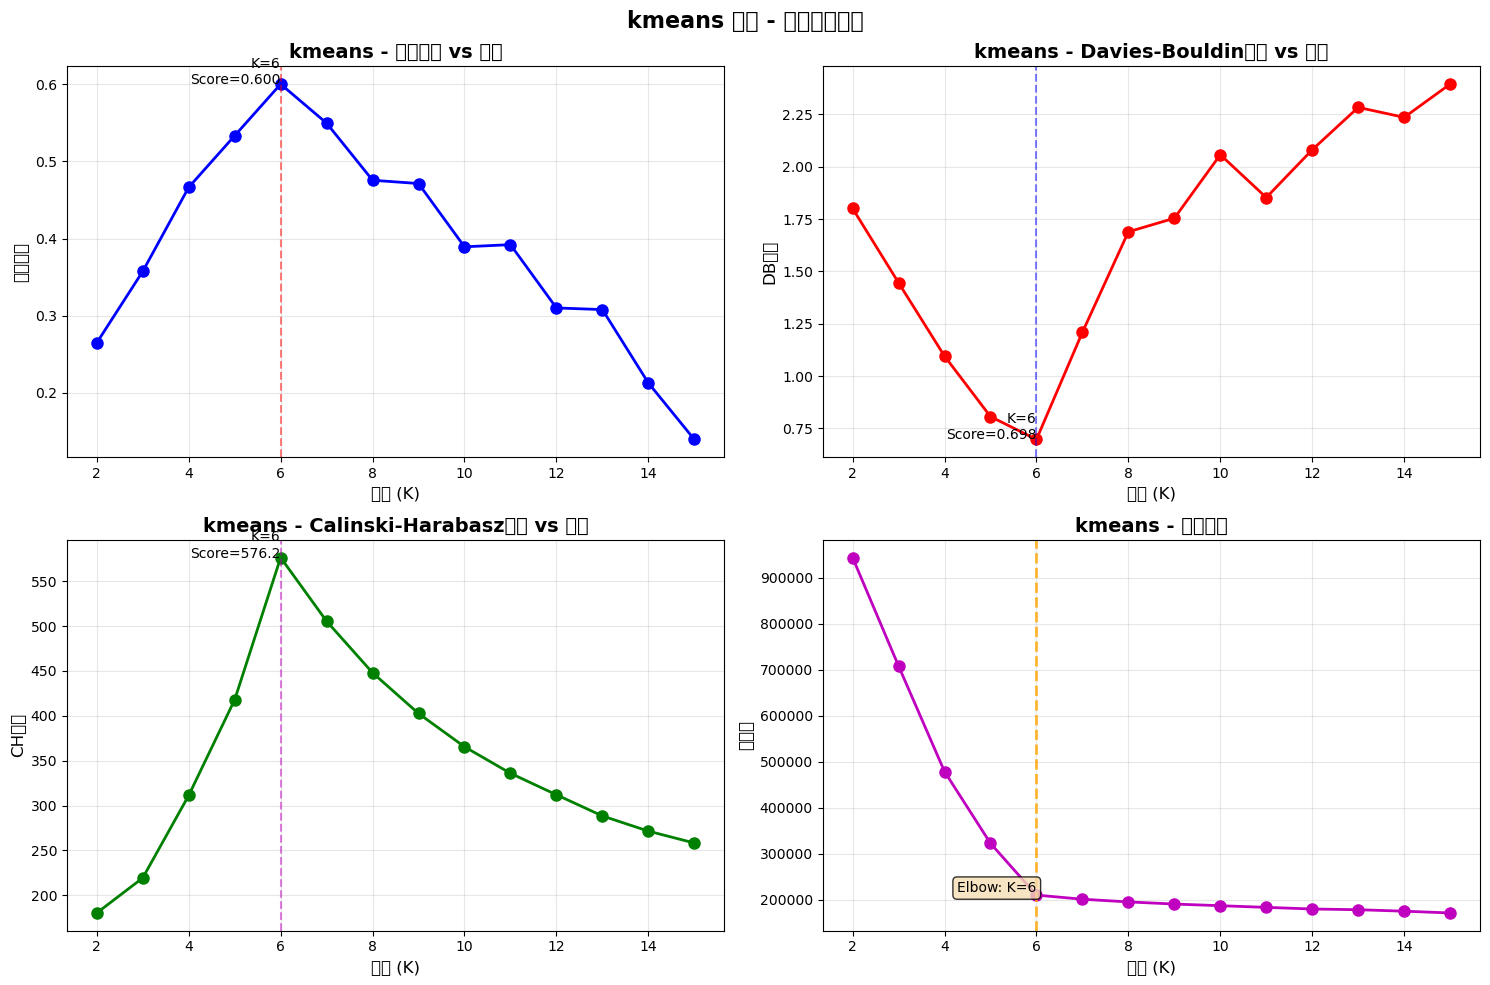


最优簇数建议:
基于silhouette: K = 6
基于davies_bouldin: K = 6
基于calinski_harabasz: K = 6
综合建议: K = 6

2. 应用聚类 - 方法: kmeans, 簇数: 6
应用 kmeans 聚类算法...
K-means完成，惯性值: 210037.84
聚类完成，发现 6 个簇
簇标签分布: {0: 100, 1: 100, 2: 100, 3: 100, 4: 100, 5: 100}
耗时: 0.31秒

3. 评估聚类效果
正在评估聚类效果...
计算内部评估指标...
计算外部评估指标...
计算聚类质量统计...
评估完成！

聚类评估报告

1. 内部评估指标（无监督）:
   轮廓系数 (Silhouette Score): 0.6001
   Davies-Bouldin指数: 0.6977
   Calinski-Harabasz指数: 576.2

2. 外部评估指标（有监督）:
   调整兰德指数 (ARI): 1.0000
   标准化互信息 (NMI): 1.0000
   同质性 (Homogeneity): 1.0000
   完整性 (Completeness): 1.0000
   V-measure: 1.0000
   Fowlkes-Mallows指数: 1.0000
   纯度 (Purity): nan

3. 聚类统计:
   发现的簇数: 6
   噪声点数量: 0
   簇大小分布:
     簇 0: 100 个样本
     簇 1: 100 个样本
     簇 2: 100 个样本
     簇 3: 100 个样本
     簇 4: 100 个样本
     簇 5: 100 个样本

4. 降维可视化 - 方法: tsne
使用 tsne 方法降维...
t-SNE降维可能需要较长时间，请耐心等待...
特征维度较高，先使用PCA预降维...
PCA预降维完成，保留方差: 0.946
t-SNE完成，耗时: 1.79秒

5. 可视化结果
正在生成可视化结果...


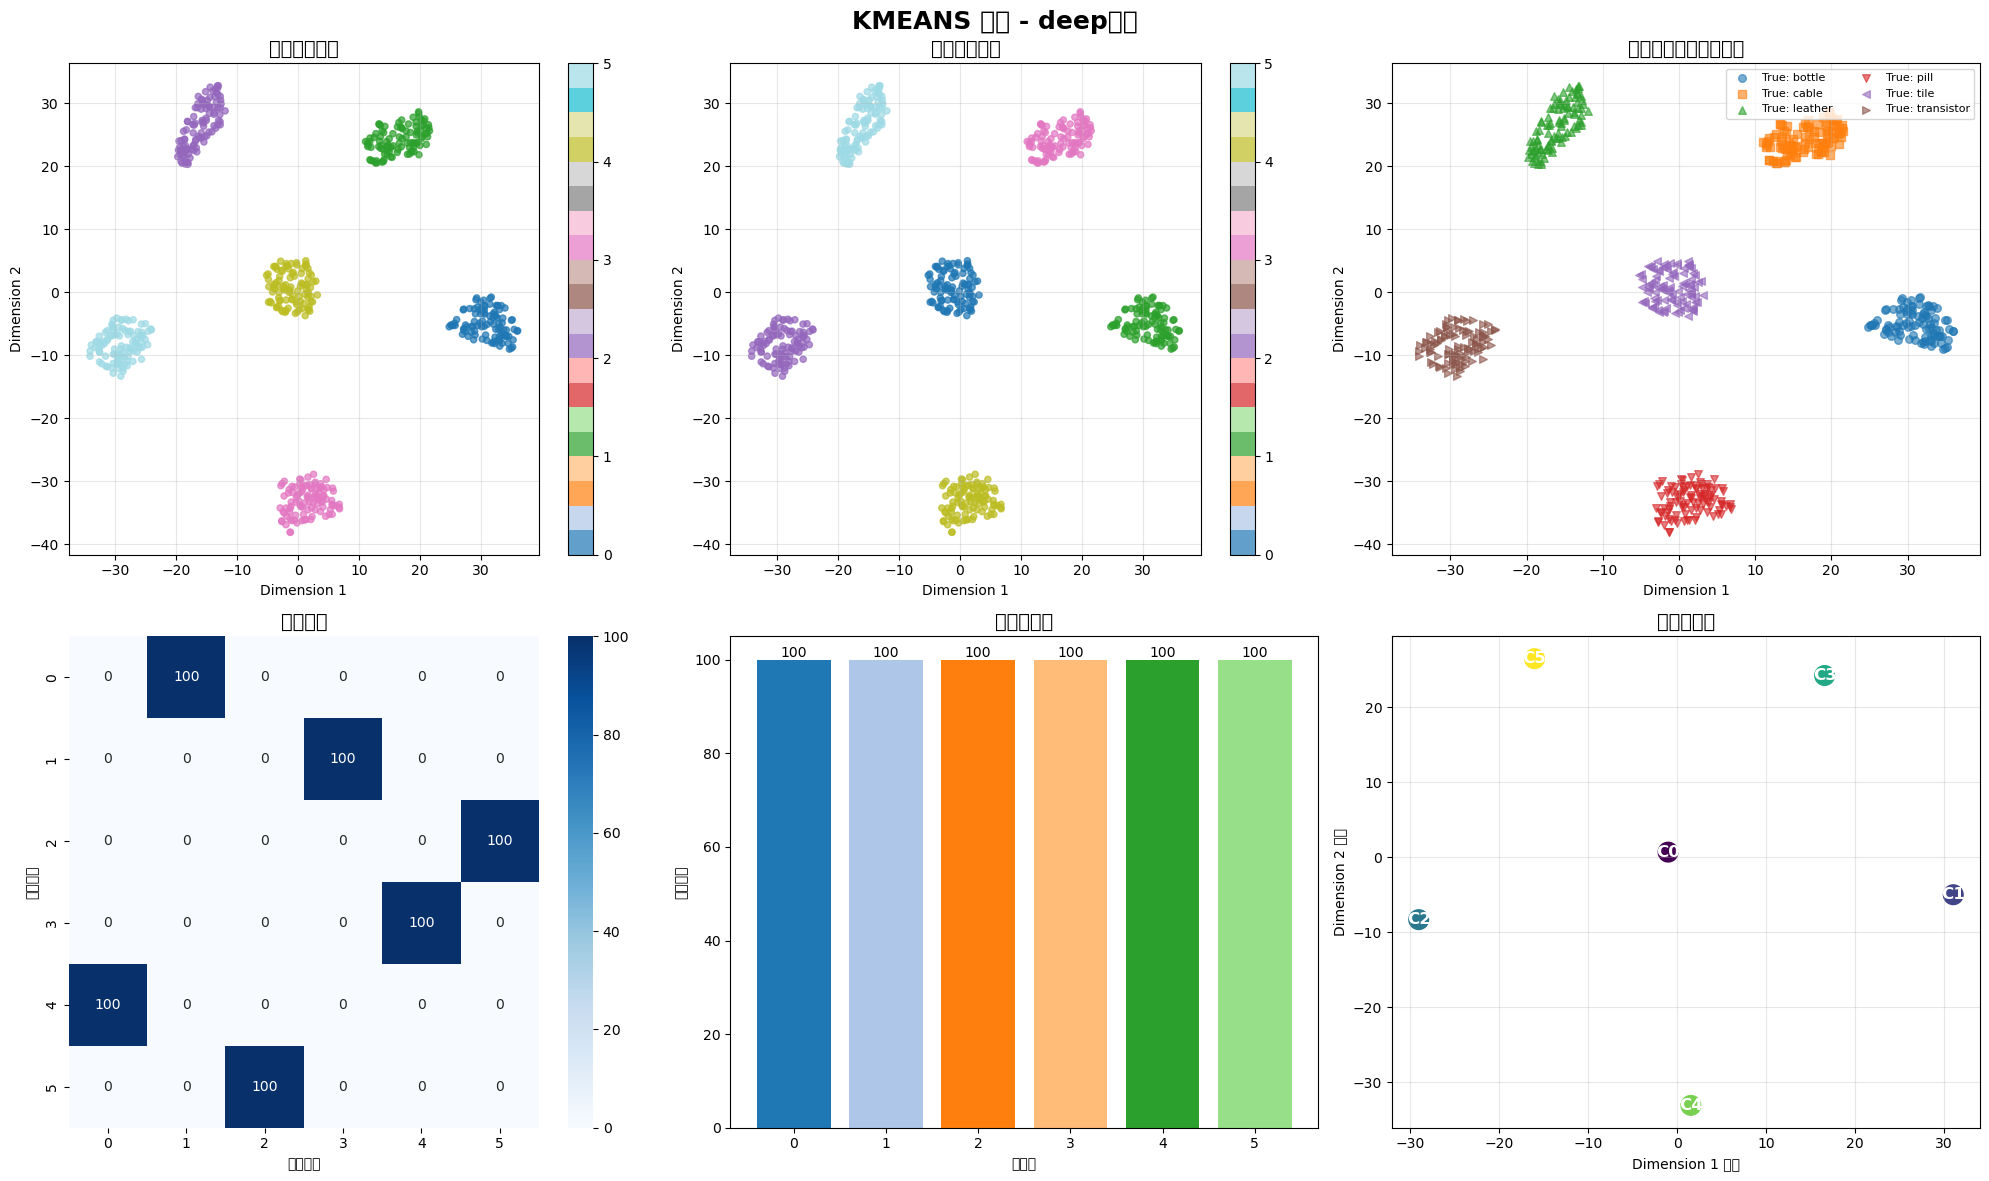

可视化完成！

6. 保存结果
保存结果到目录: clustering_results_20251222_185447
  聚类结果保存到: clustering_results_20251222_185447\clustering_results.csv
  评估指标保存到: clustering_results_20251222_185447\evaluation_metrics.csv
  特征矩阵保存到: clustering_results_20251222_185447\features.npy
  2D特征保存到: clustering_results_20251222_185447\features_2d.npy
  标签映射保存到: clustering_results_20251222_185447\label_mapping.csv
  散点图保存到: clustering_results_20251222_185447\cluster_scatter.png
  对比图保存到: clustering_results_20251222_185447\comparison_plot.png
  簇分布图保存到: clustering_results_20251222_185447\cluster_distribution.png
  运行摘要保存到: clustering_results_20251222_185447\summary.txt
所有结果已保存到目录: clustering_results_20251222_185447

流程完成！总耗时: 107.29秒

主聚类分析完成！
最佳调整兰德指数 (ARI): 1.000


In [9]:
# Cell 8: 运行完整聚类流程
print("="*80)
print("开始主聚类分析")
print("="*80)

try:
    # 运行完整流程
    results = clusterer.run_full_pipeline(
        feature_type='deep',  # 使用深度特征
        clustering_method='kmeans',  # 使用K-means聚类
        n_clusters=6,  # 指定簇数为6（根据您的数据类别数）
        reduction_method='tsne',  # 使用t-SNE降维
        find_optimal_k=True,  # 寻找最优K值
        save_results=True  # 保存结果
    )
    
    print("\n主聚类分析完成！")
    print(f"最佳调整兰德指数 (ARI): {results['metrics'].get('adjusted_rand_score', 'N/A'):.3f}")
    
except Exception as e:
    print(f"运行完整流程时出错: {e}")
    print("错误详情:")
    traceback.print_exc()
    
    print("\n尝试简化流程...")
    try:
        # 尝试简化版本
        print("1. 提取特征...")
        features = clusterer.extract_features()
        
        print("2. 应用K-means聚类...")
        clusterer.apply_clustering(features, method='kmeans', n_clusters=6)
        
        print("3. 评估聚类效果...")
        metrics = clusterer.evaluate_clustering(features)
        clusterer.print_evaluation_report(metrics)
        
    except Exception as e2:
        print(f"简化流程也失败: {e2}")


比较不同聚类方法
聚类方法比较功能已更新！现在运行比较...
开始聚类方法比较

1. 提取特征 - 类型: deep
正在提取深度特征...


提取深度特征: 100%|██████████| 19/19 [01:18<00:00,  4.16s/it]


深度特征提取完成，特征形状: (600, 2048)

2. 降维以便可视化
使用 tsne 方法降维...
t-SNE降维可能需要较长时间，请耐心等待...
特征维度较高，先使用PCA预降维...
PCA预降维完成，保留方差: 0.946
t-SNE完成，耗时: 1.66秒

3. 比较聚类方法

  KMEANS 方法:
应用 kmeans 聚类算法...
K-means完成，惯性值: 210037.84
聚类完成，发现 6 个簇
簇标签分布: {0: 100, 1: 100, 2: 100, 3: 100, 4: 100, 5: 100}
耗时: 0.22秒
正在评估聚类效果...
计算内部评估指标...
计算外部评估指标...
计算聚类质量统计...
评估完成！
    ARI: 1.000, NMI: 1.000, 轮廓系数: 0.600

  AGGLOMERATIVE 方法:
应用 agglomerative 聚类算法...
层次聚类完成
聚类完成，发现 6 个簇
簇标签分布: {0: 100, 1: 100, 2: 100, 3: 100, 4: 100, 5: 100}
耗时: 0.12秒
正在评估聚类效果...
计算内部评估指标...
计算外部评估指标...
计算聚类质量统计...
评估完成！
    ARI: 1.000, NMI: 1.000, 轮廓系数: 0.600

  GMM 方法:
应用 gmm 聚类算法...
尝试GMM聚类，正在调整参数以增强稳定性...
尝试GMM配置 1/3: covariance_type=diag, reg_covar=0.0001
GMM配置 1 成功! BIC: 551169.28, AIC: 443088.35
聚类完成，发现 6 个簇
簇标签分布: {0: 200, 1: 100, 2: 100, 3: 100, 4: 55, 5: 45}
耗时: 0.05秒
正在评估聚类效果...
计算内部评估指标...
计算外部评估指标...
计算聚类质量统计...
评估完成！
    ARI: 0.772, NMI: 0.900, 轮廓系数: 0.483


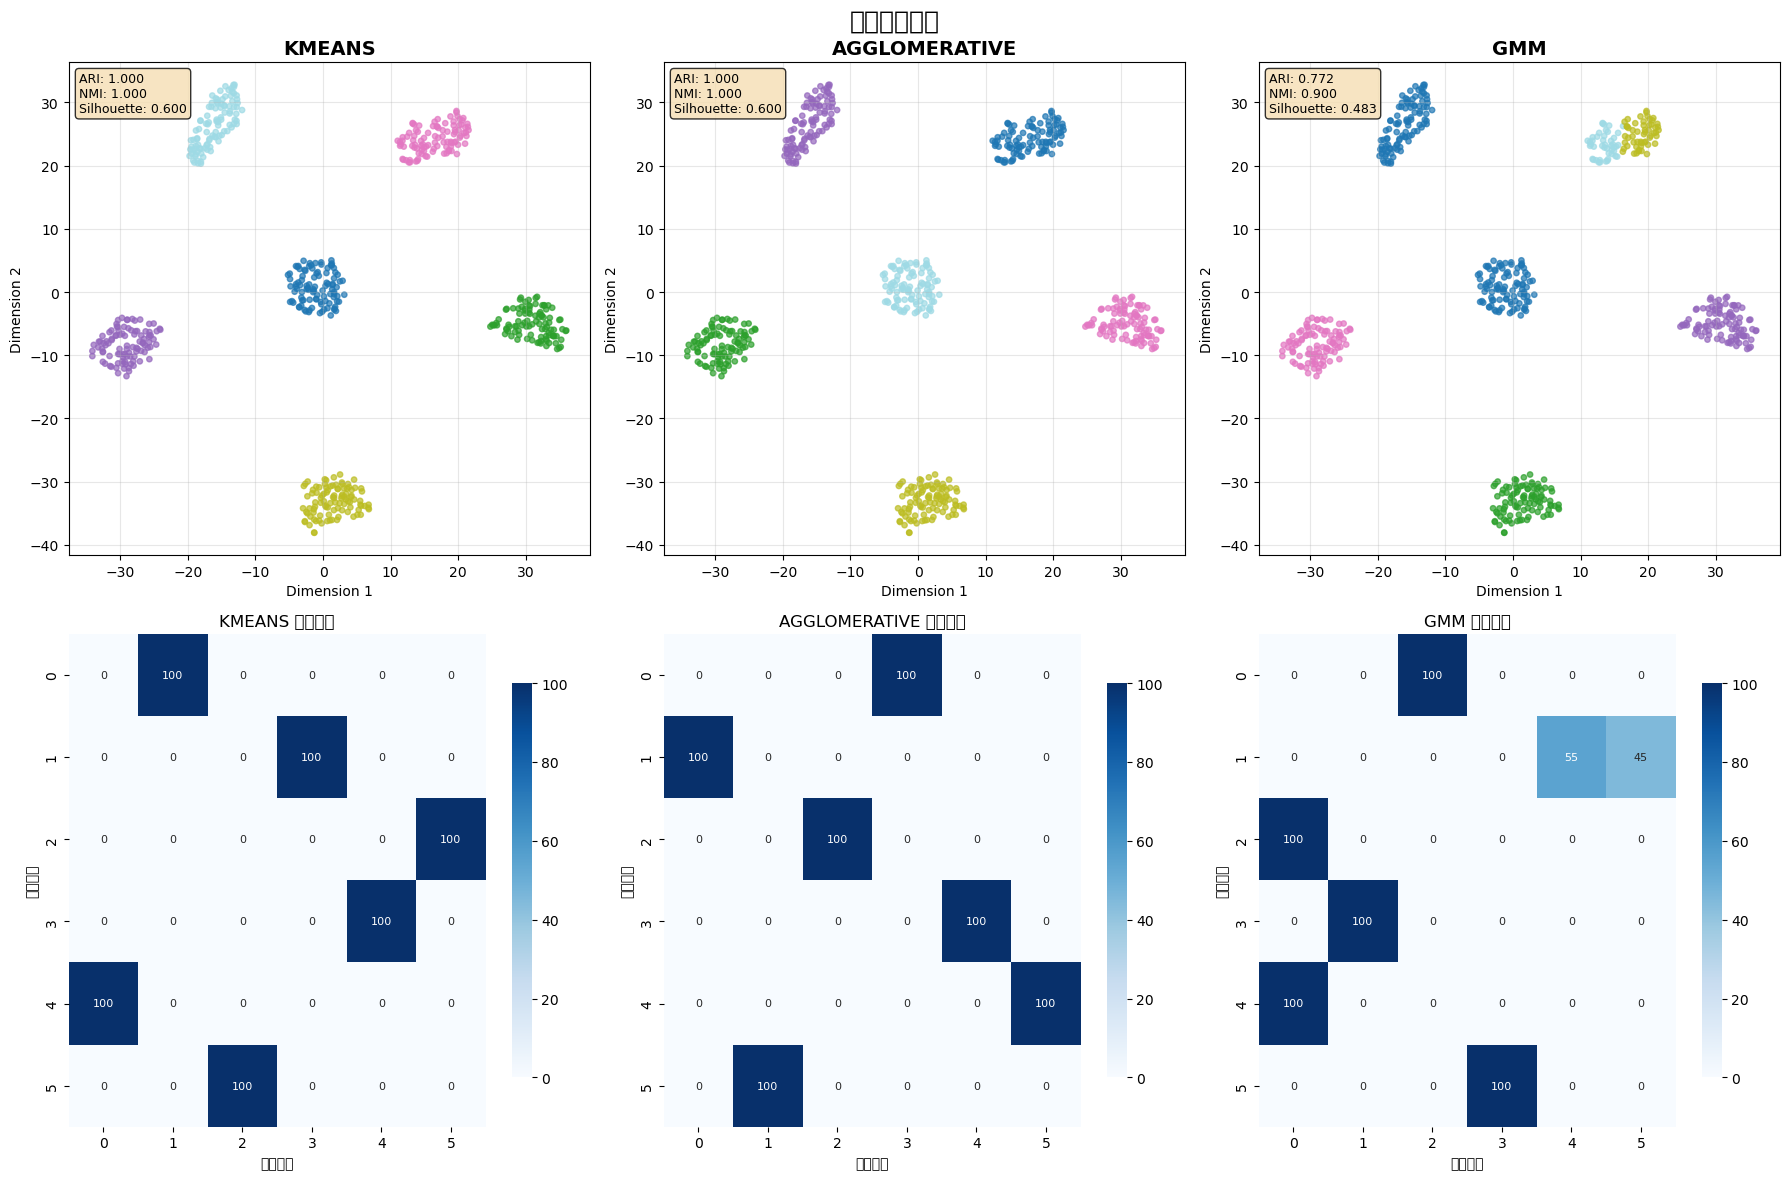


4. 方法比较总结:

聚类方法性能比较:
              adjusted_rand_score normalized_mutual_info    silhouette_score davies_bouldin_score           v_measure purity n_clusters_found n_noise_points
kmeans                        1.0                    1.0   0.600118100643158   0.6976694430020621                 1.0    nan                6              0
agglomerative                 1.0                    1.0   0.600118100643158   0.6976694430020621                 1.0    nan                6              0
gmm            0.7716048203523952     0.9002818173009857  0.4825684726238251   1.3862661209624225  0.9002818173009857    nan                6              0

最佳方法:
  ARI: kmeans (1.000)
  NMI: kmeans (1.000)
  轮廓系数: kmeans (0.600)
  DB指数: kmeans (0.698)

综合推荐 (基于ARI): kmeans (ARI: 1.000)

聚类方法比较完成！
最佳聚类方法: kmeans (ARI: 1.000)


In [10]:
# Cell 9: 比较不同聚类方法 (修正版)
print("\n" + "="*80)
print("比较不同聚类方法")
print("="*80)

def compare_clustering_methods(self, feature_type=None, methods=None, n_clusters=None):
    """
    比较不同聚类方法的效果 - 修正版本
    
    参数:
    feature_type: 特征类型 ('deep', 'hybrid', 'traditional')
    methods: 要比较的方法列表
    n_clusters: 簇数
    """
    
    if feature_type is not None:
        self.feature_type = feature_type
    
    if methods is None:
        methods = ['kmeans', 'agglomerative', 'gmm', 'dbscan']
    
    if n_clusters is None:
        n_clusters = len(self.label_encoder)
    
    print("="*70)
    print("开始聚类方法比较")
    print("="*70)
    
    # 1. 提取特征
    print(f"\n1. 提取特征 - 类型: {self.feature_type}")
    features = self.extract_features()
    
    # 2. 降维以便可视化
    print(f"\n2. 降维以便可视化")
    features_2d = self.reduce_dimension(features, method='tsne')
    
    # 3. 比较不同方法
    print(f"\n3. 比较聚类方法")
    all_metrics = {}
    
    # 创建子图：2行，每行len(methods)列
    fig, axes = plt.subplots(2, len(methods), figsize=(6*len(methods), 12))
    
    # 如果只有一种方法，调整axes形状
    if len(methods) == 1:
        axes = axes.reshape(2, 1)
    
    for idx, method in enumerate(methods):
        print(f"\n  {method.upper()} 方法:")
        
        try:
            # 应用聚类
            cluster_labels = self.apply_clustering(features, method=method, n_clusters=n_clusters)
            
            # 评估聚类效果
            metrics = self.evaluate_clustering(features)
            all_metrics[method] = metrics
            
            # 获取当前方法的子图位置
            ax_scatter = axes[0, idx]  # 第一行：散点图
            ax_cm = axes[1, idx]      # 第二行：混淆矩阵
            
            # 1. 绘制聚类结果散点图
            scatter = ax_scatter.scatter(features_2d[:, 0], features_2d[:, 1], 
                                       c=cluster_labels, cmap='tab20', alpha=0.7, s=15)
            ax_scatter.set_title(f'{method.upper()}', fontsize=14, fontweight='bold')
            ax_scatter.set_xlabel('Dimension 1')
            ax_scatter.set_ylabel('Dimension 2')
            ax_scatter.grid(True, alpha=0.3)
            
            # 在图上显示关键指标
            ari = metrics.get('adjusted_rand_score', 0)
            nmi = metrics.get('normalized_mutual_info', 0)
            silhouette = metrics.get('silhouette_score', 0)
            info_text = f"ARI: {ari:.3f}\nNMI: {nmi:.3f}\nSilhouette: {silhouette:.3f}"
            ax_scatter.text(0.02, 0.98, info_text, transform=ax_scatter.transAxes,
                           verticalalignment='top', fontsize=9,
                           bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
            
            # 2. 绘制混淆矩阵
            # 确保聚类标签从0开始连续（排除噪声标签-1）
            unique_clusters = np.unique(cluster_labels)
            valid_clusters = unique_clusters[unique_clusters != -1]
            
            if len(valid_clusters) > 0:
                # 重新映射聚类标签为连续整数
                if -1 in unique_clusters:
                    # 处理噪声点：将-1映射为最后一个标签
                    cluster_labels_mapped = np.where(cluster_labels == -1, 
                                                    len(valid_clusters), 
                                                    cluster_labels)
                else:
                    cluster_labels_mapped = cluster_labels
                
                # 计算混淆矩阵
                cm = confusion_matrix(self.true_labels_encoded, cluster_labels_mapped)
                
                # 限制混淆矩阵大小以便显示
                max_size = 10
                if cm.shape[0] > max_size or cm.shape[1] > max_size:
                    # 截取前max_size个类别
                    cm = cm[:max_size, :max_size]
                    ax_cm.set_title(f'{method.upper()} 混淆矩阵 (前{max_size}个类别)', fontsize=12)
                else:
                    ax_cm.set_title(f'{method.upper()} 混淆矩阵', fontsize=12)
                
                # 绘制热力图
                sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax_cm, 
                           cbar_kws={'shrink': 0.8})
                ax_cm.set_xlabel('聚类标签')
                ax_cm.set_ylabel('真实标签')
                
                # 如果混淆矩阵太大，调整字体大小
                if cm.shape[0] > 5 or cm.shape[1] > 5:
                    for text in ax_cm.texts:
                        text.set_fontsize(8)
            else:
                ax_cm.text(0.5, 0.5, '无有效聚类结果', 
                          ha='center', va='center', transform=ax_cm.transAxes,
                          fontsize=12, color='red')
                ax_cm.set_title(f'{method.upper()} - 无有效聚类', fontsize=12)
                ax_cm.set_axis_off()
            
            print(f"    ARI: {metrics.get('adjusted_rand_score', 'N/A'):.3f}, "
                  f"NMI: {metrics.get('normalized_mutual_info', 'N/A'):.3f}, "
                  f"轮廓系数: {metrics.get('silhouette_score', 'N/A'):.3f}")
                  
        except Exception as e:
            print(f"   错误: {e}")
            all_metrics[method] = {'error': str(e)}
            
            # 在子图中显示错误信息
            if len(methods) > 1:
                axes[0, idx].text(0.5, 0.5, f'错误:\n{str(e)[:50]}...', 
                                 ha='center', va='center', 
                                 transform=axes[0, idx].transAxes,
                                 fontsize=10, color='red')
                axes[0, idx].set_title(f'{method.upper()} - 失败', fontsize=12, color='red')
                axes[0, idx].set_axis_off()
                
                axes[1, idx].text(0.5, 0.5, '聚类失败', 
                                 ha='center', va='center', 
                                 transform=axes[1, idx].transAxes,
                                 fontsize=12, color='red')
                axes[1, idx].set_axis_off()
            else:
                axes[0].text(0.5, 0.5, f'错误:\n{str(e)[:50]}...', 
                            ha='center', va='center', transform=axes[0].transAxes,
                            fontsize=10, color='red')
                axes[0].set_title(f'{method.upper()} - 失败', fontsize=12, color='red')
                axes[0].set_axis_off()
                
                axes[1].text(0.5, 0.5, '聚类失败', 
                            ha='center', va='center', transform=axes[1].transAxes,
                            fontsize=12, color='red')
                axes[1].set_axis_off()
    
    plt.suptitle('聚类方法比较', fontsize=18, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # 4. 创建比较表格
    print(f"\n4. 方法比较总结:")
    metrics_df = pd.DataFrame(all_metrics).T
    
    # 选择要显示的指标
    display_metrics = ['adjusted_rand_score', 'normalized_mutual_info', 
                      'silhouette_score', 'davies_bouldin_score', 
                      'v_measure', 'purity', 'n_clusters_found', 'n_noise_points']
    
    # 只显示存在的指标
    available_metrics = [m for m in display_metrics if m in metrics_df.columns]
    display_df = metrics_df[available_metrics].copy()
    
    # 格式化显示
    for col in display_df.columns:
        if display_df[col].dtype == 'float64':
            display_df[col] = display_df[col].apply(lambda x: f"{x:.3f}" if not pd.isna(x) else "N/A")
        elif display_df[col].dtype == 'object':
            # 如果是字符串（如错误信息），只显示前50个字符
            display_df[col] = display_df[col].apply(lambda x: str(x)[:50] + "..." if len(str(x)) > 50 else str(x))
    
    print("\n聚类方法性能比较:")
    print(display_df.to_string())
    
    # 找出最佳方法
    best_methods = {}
    for metric in ['adjusted_rand_score', 'normalized_mutual_info', 'silhouette_score', 'davies_bouldin_score']:
        if metric in metrics_df.columns:
            # 转换为数值，处理错误情况
            valid_values = pd.to_numeric(metrics_df[metric], errors='coerce')
            if not valid_values.isna().all():
                if metric == 'davies_bouldin_score':
                    # DB指数越低越好
                    valid_values_clean = valid_values.dropna()
                    if len(valid_values_clean) > 0:
                        best_idx = valid_values_clean.idxmin()
                        best_methods[metric] = (best_idx, valid_values_clean.min())
                else:
                    # 其他指标越高越好
                    valid_values_clean = valid_values.dropna()
                    if len(valid_values_clean) > 0:
                        best_idx = valid_values_clean.idxmax()
                        best_methods[metric] = (best_idx, valid_values_clean.max())
    
    if best_methods:
        print("\n最佳方法:")
        for metric, (method, value) in best_methods.items():
            metric_name = {
                'adjusted_rand_score': 'ARI',
                'normalized_mutual_info': 'NMI', 
                'silhouette_score': '轮廓系数',
                'davies_bouldin_score': 'DB指数'
            }.get(metric, metric)
            print(f"  {metric_name}: {method} ({value:.3f})")
        
        # 综合推荐
        ari_scores = {}
        for method in methods:
            if method in all_metrics and 'adjusted_rand_score' in all_metrics[method]:
                ari_scores[method] = all_metrics[method]['adjusted_rand_score']
        
        if ari_scores:
            best_method_ari = max(ari_scores, key=ari_scores.get)
            print(f"\n综合推荐 (基于ARI): {best_method_ari} (ARI: {ari_scores[best_method_ari]:.3f})")
    else:
        print("\n无法确定最佳方法 - 所有方法都失败或缺少评估指标")
    
    print("="*70)
    
    return {
        'features': features,
        'features_2d': features_2d,
        'all_metrics': all_metrics,
        'comparison_df': metrics_df
    }

# 将修正后的方法添加到类中（替换原有的）
ImageClustering.compare_clustering_methods = compare_clustering_methods

print("聚类方法比较功能已更新！现在运行比较...")

try:
    # 运行修正后的聚类方法比较
    comparison_results = clusterer.compare_clustering_methods(
        feature_type='deep',  # 使用深度特征
        methods=['kmeans', 'agglomerative', 'gmm'],  # 比较的方法
        n_clusters=6  # 簇数
    )
    
    print("\n聚类方法比较完成！")
    
    # 找出最佳方法
    all_metrics = comparison_results['all_metrics']
    best_method = None
    best_ari = -1
    
    for method, metrics in all_metrics.items():
        if 'adjusted_rand_score' in metrics:
            ari = metrics['adjusted_rand_score']
            if ari > best_ari:
                best_ari = ari
                best_method = method
    
    if best_method:
        print(f"最佳聚类方法: {best_method} (ARI: {best_ari:.3f})")
    
except Exception as e:
    print(f"比较聚类方法时出错: {e}")
    print("错误详情:")
    traceback.print_exc()


特征类型比较分析

分析特征类型: deep
正在提取深度特征...


提取深度特征: 100%|██████████| 19/19 [01:35<00:00,  5.05s/it]


深度特征提取完成，特征形状: (600, 2048)
应用 kmeans 聚类算法...
K-means完成，惯性值: 210037.84
聚类完成，发现 6 个簇
簇标签分布: {0: 100, 1: 100, 2: 100, 3: 100, 4: 100, 5: 100}
耗时: 0.62秒
正在评估聚类效果...
计算内部评估指标...
计算外部评估指标...
计算聚类质量统计...
评估完成！
  ARI: 1.000, NMI: 1.000

分析特征类型: hybrid
正在提取混合特征...
正在提取深度特征...


提取深度特征: 100%|██████████| 19/19 [03:13<00:00, 10.17s/it]


深度特征提取完成，特征形状: (600, 2048)
正在提取颜色直方图特征...


提取颜色特征: 100%|██████████| 600/600 [02:35<00:00,  3.86it/s]


颜色直方图特征形状: (600, 288)
正在提取纹理特征...


提取纹理特征: 100%|██████████| 600/600 [00:44<00:00, 13.45it/s]


纹理特征形状: (600, 72)
混合特征形状: (600, 2408)
应用 kmeans 聚类算法...
K-means完成，惯性值: 242653.04
聚类完成，发现 6 个簇
簇标签分布: {0: 100, 1: 100, 2: 100, 3: 100, 4: 100, 5: 100}
耗时: 0.09秒
正在评估聚类效果...
计算内部评估指标...
计算外部评估指标...
计算聚类质量统计...
评估完成！
  ARI: 1.000, NMI: 1.000

分析特征类型: traditional
正在提取颜色直方图特征...


提取颜色特征: 100%|██████████| 600/600 [02:29<00:00,  4.00it/s]


颜色直方图特征形状: (600, 288)
正在提取纹理特征...


提取纹理特征: 100%|██████████| 600/600 [00:47<00:00, 12.55it/s]


纹理特征形状: (600, 72)
应用 kmeans 聚类算法...
K-means完成，惯性值: 32615.16
聚类完成，发现 6 个簇
簇标签分布: {0: 100, 1: 100, 2: 100, 3: 100, 4: 100, 5: 100}
耗时: 0.02秒
正在评估聚类效果...
计算内部评估指标...
计算外部评估指标...
计算聚类质量统计...
评估完成！
  ARI: 1.000, NMI: 1.000


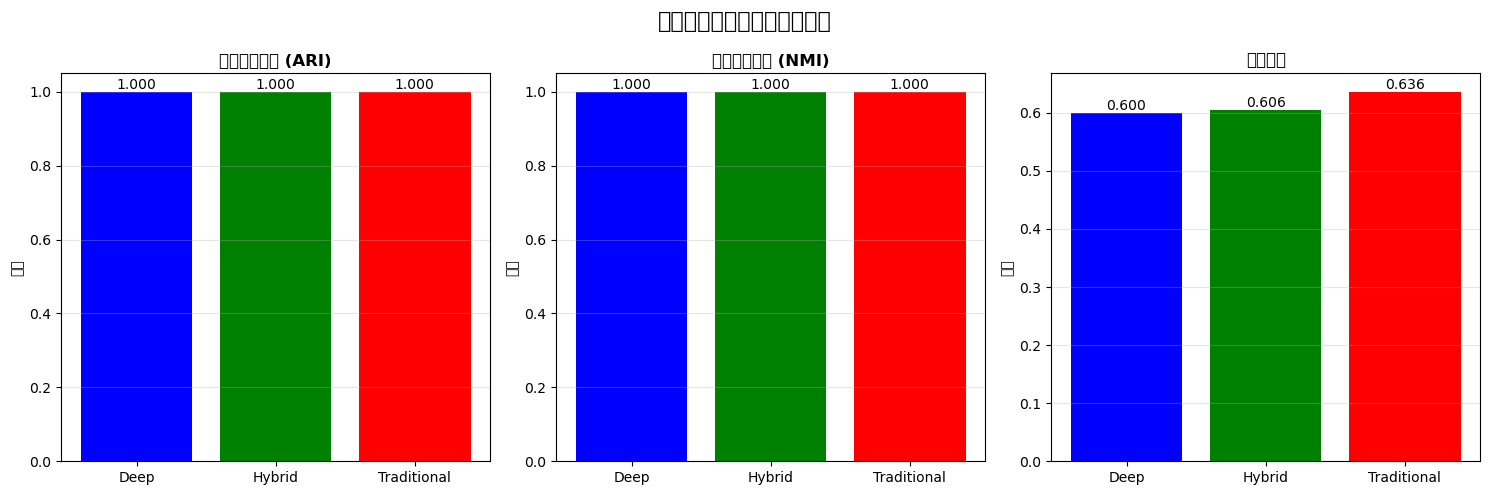


特征类型比较总结:
            adjusted_rand_score normalized_mutual_info silhouette_score davies_bouldin_score
deep                        1.0                    1.0         0.600118             0.697669
hybrid                      1.0                    1.0         0.605629             0.687839
traditional                 1.0                    1.0         0.636125             0.580821

最佳特征类型: deep (ARI: 1.000)


In [11]:
# Cell 10: 额外分析 - 特征类型比较
print("\n" + "="*80)
print("特征类型比较分析")
print("="*80)

try:
    # 保存原始特征类型
    original_feature_type = clusterer.feature_type
    
    # 比较不同特征类型
    feature_types = ['deep', 'hybrid', 'traditional']
    feature_results = {}
    
    for ftype in feature_types:
        print(f"\n分析特征类型: {ftype}")
        
        try:
            # 更新特征类型
            clusterer.feature_type = ftype
            
            # 提取特征
            features = clusterer.extract_features()
            
            # 应用K-means聚类
            clusterer.apply_clustering(features, method='kmeans', n_clusters=6)
            
            # 评估
            metrics = clusterer.evaluate_clustering(features)
            feature_results[ftype] = metrics
            
            print(f"  ARI: {metrics.get('adjusted_rand_score', 'N/A'):.3f}, "
                  f"NMI: {metrics.get('normalized_mutual_info', 'N/A'):.3f}")
                  
        except Exception as e:
            print(f"  错误: {e}")
            feature_results[ftype] = {'error': str(e)}
    
    # 恢复原始特征类型
    clusterer.feature_type = original_feature_type
    
    # 可视化比较结果
    if feature_results:
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        metrics_to_plot = ['adjusted_rand_score', 'normalized_mutual_info', 'silhouette_score']
        metric_names = ['调整兰德指数 (ARI)', '标准化互信息 (NMI)', '轮廓系数']
        
        for idx, (metric, name) in enumerate(zip(metrics_to_plot, metric_names)):
            ax = axes[idx]
            
            values = []
            labels = []
            for ftype in feature_types:
                if ftype in feature_results and metric in feature_results[ftype]:
                    value = feature_results[ftype][metric]
                    if not np.isnan(value):
                        values.append(value)
                        labels.append(ftype.capitalize())
            
            if values:
                bars = ax.bar(range(len(values)), values, color=['blue', 'green', 'red'][:len(values)])
                ax.set_title(name, fontsize=12, fontweight='bold')
                ax.set_xticks(range(len(values)))
                ax.set_xticklabels(labels)
                ax.set_ylabel('分数')
                ax.grid(True, alpha=0.3, axis='y')
                
                # 在柱状图上添加数值
                for bar in bars:
                    height = bar.get_height()
                    ax.text(bar.get_x() + bar.get_width()/2., height,
                           f'{height:.3f}', ha='center', va='bottom')
        
        plt.suptitle('不同特征类型的聚类效果比较', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.show()
        
        # 打印总结
        print("\n特征类型比较总结:")
        summary_df = pd.DataFrame(feature_results).T
        display_cols = ['adjusted_rand_score', 'normalized_mutual_info', 
                       'silhouette_score', 'davies_bouldin_score']
        
        display_summary = summary_df[display_cols].copy()
        for col in display_summary.columns:
            if display_summary[col].dtype == 'float64':
                display_summary[col] = display_summary[col].apply(
                    lambda x: f"{x:.3f}" if not pd.isna(x) else "N/A")
        
        print(display_summary.to_string())
        
        # 找出最佳特征类型
        best_ftype = None
        best_ari = -1
        for ftype, metrics in feature_results.items():
            if 'adjusted_rand_score' in metrics:
                ari = metrics['adjusted_rand_score']
                if ari > best_ari:
                    best_ari = ari
                    best_ftype = ftype
        
        if best_ftype:
            print(f"\n最佳特征类型: {best_ftype} (ARI: {best_ari:.3f})")
    
except Exception as e:
    print(f"特征类型比较时出错: {e}")
    print("错误详情:")
    traceback.print_exc()

In [12]:
# Cell 11: 生成最终报告
print("\n" + "="*80)
print("生成最终聚类分析报告")
print("="*80)

try:
    # 创建最终报告
    report_lines = []
    
    report_lines.append("="*80)
    report_lines.append("图像聚类分析最终报告")
    report_lines.append("="*80)
    report_lines.append("")
    
    # 1. 数据集信息
    report_lines.append("1. 数据集信息")
    report_lines.append(f"   图像总数: {len(clusterer.image_paths)}")
    report_lines.append(f"   类别数量: {len(clusterer.label_encoder)}")
    report_lines.append(f"   类别分布: {dict(zip(*np.unique(clusterer.true_labels, return_counts=True)))}")
    report_lines.append("")
    
    # 2. 特征提取信息
    report_lines.append("2. 特征提取")
    report_lines.append(f"   特征类型: {clusterer.feature_type}")
    if hasattr(clusterer, 'features'):
        report_lines.append(f"   特征维度: {clusterer.features.shape[1]}")
    report_lines.append("")
    
    # 3. 聚类结果（如果有）
    if hasattr(clusterer, 'cluster_labels'):
        report_lines.append("3. 聚类结果")
        unique_clusters = np.unique(clusterer.cluster_labels)
        n_clusters = len(unique_clusters[unique_clusters != -1])  # 排除噪声点
        
        report_lines.append(f"   发现的簇数: {n_clusters}")
        
        cluster_sizes = dict(zip(*np.unique(clusterer.cluster_labels, return_counts=True)))
        report_lines.append(f"   簇大小分布: {cluster_sizes}")
        report_lines.append("")
        
        # 如果有评估指标
        if hasattr(clusterer, 'last_metrics'):
            report_lines.append("4. 评估指标")
            metrics = clusterer.last_metrics
            
            if 'adjusted_rand_score' in metrics:
                ari = metrics['adjusted_rand_score']
                interpretation = ""
                if ari > 0.9:
                    interpretation = "(优秀)"
                elif ari > 0.7:
                    interpretation = "(良好)"
                elif ari > 0.5:
                    interpretation = "(中等)"
                else:
                    interpretation = "(较差)"
                
                report_lines.append(f"   调整兰德指数 (ARI): {ari:.3f} {interpretation}")
            
            if 'normalized_mutual_info' in metrics:
                nmi = metrics['normalized_mutual_info']
                report_lines.append(f"   标准化互信息 (NMI): {nmi:.3f}")
            
            if 'v_measure' in metrics:
                v_measure = metrics['v_measure']
                report_lines.append(f"   V-measure: {v_measure:.3f}")
            
            if 'purity' in metrics:
                purity = metrics['purity']
                report_lines.append(f"   纯度 (Purity): {purity:.3f}")
    
    # 4. 建议
    report_lines.append("")
    report_lines.append("5. 结论与建议")
    report_lines.append("   1. 如果ARI > 0.8，聚类效果优秀，可以直接使用聚类结果")
    report_lines.append("   2. 如果ARI在0.5-0.8之间，聚类效果中等，可以考虑调整参数")
    report_lines.append("   3. 如果ARI < 0.5，聚类效果较差，可能需要:")
    report_lines.append("      - 尝试不同的特征提取方法")
    report_lines.append("      - 调整聚类算法参数")
    report_lines.append("      - 检查数据质量")
    report_lines.append("   4. 建议同时查看可视化结果，直观判断聚类质量")
    report_lines.append("")
    report_lines.append("="*80)
    
    # 打印报告
    for line in report_lines:
        print(line)
    
    # 保存报告到文件
    report_path = "clustering_final_report.txt"
    with open(report_path, 'w', encoding='utf-8') as f:
        f.write('\n'.join(report_lines))
    
    print(f"\n最终报告已保存到: {report_path}")
    
except Exception as e:
    print(f"生成最终报告时出错: {e}")
    print("错误详情:")
    traceback.print_exc()


生成最终聚类分析报告
图像聚类分析最终报告

1. 数据集信息
   图像总数: 600
   类别数量: 6
   类别分布: {'bottle': 100, 'cable': 100, 'leather': 100, 'pill': 100, 'tile': 100, 'transistor': 100}

2. 特征提取
   特征类型: deep
   特征维度: 2048

3. 聚类结果
   发现的簇数: 6
   簇大小分布: {0: 100, 1: 100, 2: 100, 3: 100, 4: 100, 5: 100}


5. 结论与建议
   1. 如果ARI > 0.8，聚类效果优秀，可以直接使用聚类结果
   2. 如果ARI在0.5-0.8之间，聚类效果中等，可以考虑调整参数
   3. 如果ARI < 0.5，聚类效果较差，可能需要:
      - 尝试不同的特征提取方法
      - 调整聚类算法参数
      - 检查数据质量
   4. 建议同时查看可视化结果，直观判断聚类质量


最终报告已保存到: clustering_final_report.txt



可视化样本图像和聚类结果


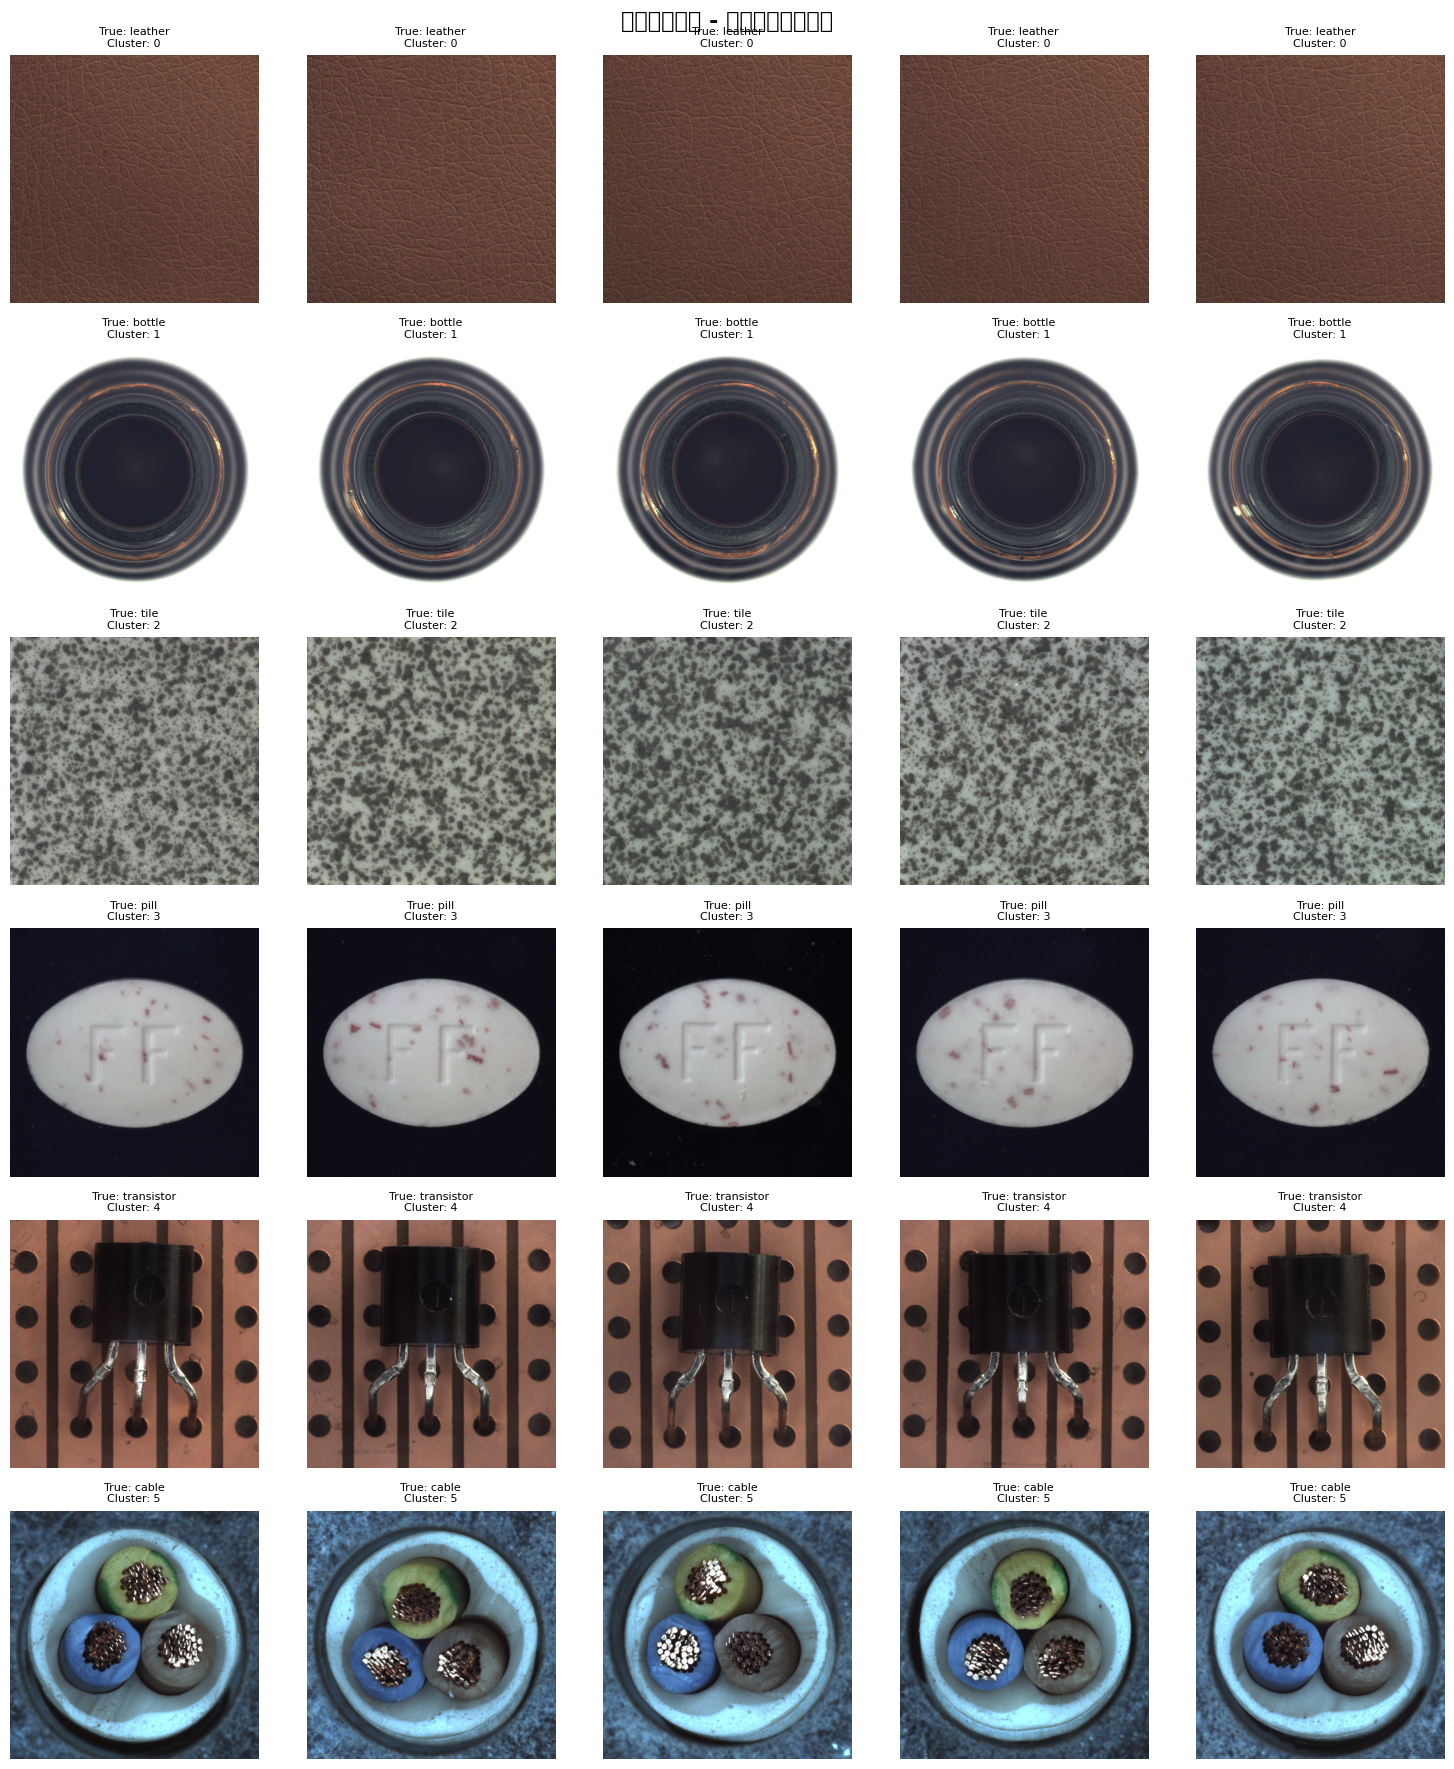

显示了 6 个簇，每个簇 5 张样本图像


In [13]:
# Cell 12: 可视化样本图像（可选）
print("\n" + "="*80)
print("可视化样本图像和聚类结果")
print("="*80)

try:
    # 检查是否已进行聚类
    if hasattr(clusterer, 'cluster_labels') and clusterer.cluster_labels is not None:
        # 每个簇显示一些样本图像
        unique_clusters = np.unique(clusterer.cluster_labels)
        n_clusters = len(unique_clusters)
        
        # 设置每个簇显示的图像数量
        n_samples_per_cluster = 5
        
        # 创建可视化
        fig, axes = plt.subplots(n_clusters, n_samples_per_cluster, 
                                figsize=(n_samples_per_cluster * 3, n_clusters * 3))
        
        if n_clusters == 1:
            axes = axes.reshape(1, -1)
        
        for i, cluster_id in enumerate(unique_clusters):
            # 获取属于该簇的图像索引
            cluster_indices = np.where(clusterer.cluster_labels == cluster_id)[0]
            
            # 随机选择样本（如果可用）
            if len(cluster_indices) > n_samples_per_cluster:
                sample_indices = np.random.choice(cluster_indices, n_samples_per_cluster, replace=False)
            else:
                sample_indices = cluster_indices[:n_samples_per_cluster]
            
            for j, idx in enumerate(sample_indices):
                if j < n_samples_per_cluster:  # 确保不超出列数
                    try:
                        # 加载图像
                        img_path = clusterer.image_paths[idx]
                        img = Image.open(img_path)
                        
                        # 显示图像
                        if n_clusters > 1:
                            ax = axes[i, j]
                        else:
                            ax = axes[j]
                        
                        ax.imshow(img)
                        ax.axis('off')
                        
                        # 添加标题
                        true_label = clusterer.true_labels[idx]
                        cluster_label = clusterer.cluster_labels[idx]
                        ax.set_title(f"True: {true_label}\nCluster: {cluster_label}", 
                                   fontsize=8)
                        
                    except Exception as e:
                        if n_clusters > 1:
                            axes[i, j].axis('off')
                            axes[i, j].set_title("加载失败", fontsize=8)
                        else:
                            axes[j].axis('off')
                            axes[j].set_title("加载失败", fontsize=8)
        
        # 设置行标题
        for i, cluster_id in enumerate(unique_clusters):
            cluster_size = np.sum(clusterer.cluster_labels == cluster_id)
            if n_clusters > 1:
                axes[i, 0].set_ylabel(f'Cluster {cluster_id}\n({cluster_size}张)', 
                                    rotation=0, ha='right', fontsize=10, fontweight='bold')
        
        plt.suptitle('聚类结果示例 - 每个簇的样本图像', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.show()
        
        print(f"显示了 {n_clusters} 个簇，每个簇 {n_samples_per_cluster} 张样本图像")
    else:
        print("尚未进行聚类，无法显示样本图像")
        
except Exception as e:
    print(f"可视化样本图像时出错: {e}")
    print("这可能是因为图像文件无法加载或显示设置问题")